# Black hole segmentation

### Imports of necessary libraries

In [1]:
# Standard libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import glob

# PyTorch libraries
import torch
import torch.optim as optim
from torch.utils.data import DataLoader


# Libraries from MONAI (Medical Open Network for AI)
from monai.networks.nets import UNet
from monai.transforms import LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensityd, ToTensord, CropForegroundd, Resized, RandFlipd, RandRotate90d, RandZoomd, Compose, EnsureTyped, AsDiscrete
from monai.data import Dataset
from monai.losses import DiceLoss
from monai.metrics import DiceMetric


# Set a seed to ensure reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

random.seed(42)
np.random.seed(42)

## Training and evaluation functions

A training and an evaluation function were defined. Both of these had the T2 lesion mask as an optional input argument, ensuring their applicability to both U-Net frameworks. Additionally an evaluation function was defined to evaluate the model by calculating the Dice score coefficient. To visualize the performance, another function was defined to compare predictions and ground truth. 

In [2]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, les_mask=False, val_loader=None):

    """
    Trains a PyTorch model on a given dataset and optionally evaluates on validation data

    Args:
        n_epochs (int): Number of training iterations (epochs)
        optimizer (torch.optim.Optimizer): Optimization algorithm used for training
        model (torch.nn.Module): The model to train
        loss_fn (callable): Loss function to minimize
        train_loader (DataLoader): DataLoader for the training dataset
        les_mask (bool, optional): If True, includes T2 lesion masks as a second input channel. Defaults to False
        val_loader (DataLoader, optional): DataLoader for the validation dataset. If provided, validation loss is logged each epoch

    Returns:
        list or tuple: If val_loader is None, returns a list of training losses. Otherwise, returns a tuple (training_losses, validation_losses)
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses_train = []
    losses_val = [] if val_loader is not None else None

    # Training the model
    for epoch in range(1, n_epochs + 1):
        model.train()
        loss_train = 0.0

        for batch_data in train_loader:
            imgs = batch_data["image"].to(device)
            lesion_mask = batch_data["lesion_mask"].to(device) if les_mask else None
            labels = batch_data["label"].to(device)

            # Combining the MRI volume with the T2 lesion mask as channels if les_mask is True
            if les_mask:
                imgs = torch.cat([imgs, lesion_mask], dim=1)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        losses_train.append(loss_train / len(train_loader))

        # Validation
        if val_loader is not None:
            model.eval()
            loss_val = 0.0
            with torch.no_grad():
                for batch_data in val_loader:
                    imgs = batch_data["image"].to(device)
                    lesion_mask = batch_data["lesion_mask"].to(device) if les_mask else None
                    labels = batch_data["label"].to(device)

                    # Combining the MRI volume with the T2 lesion mask as channels if les_mask is True
                    if les_mask:
                        imgs = torch.cat([imgs, lesion_mask], dim=1)

                    outputs = model(imgs)
                    loss = loss_fn(outputs, labels)
                    loss_val += loss.item()

            losses_val.append(loss_val / len(val_loader))

        # Logging the losses
        print(f"Epoch {epoch} | Training Loss: {losses_train[-1]:.4f}", end="")
        if val_loader is not None:
            print(f" | Validation Loss: {losses_val[-1]:.4f}")
        else:
            print("")

    return (losses_train, losses_val) if val_loader is not None else losses_train


In [3]:
def plot_losses(train_loss, val_loss, dataset, channels, lr, wd, do, x_values):

    """
    Plots the training loss together with the validation or test loss across the epochs

    Args:
        train_loss (list): Training losses across all iterations
        val_loss (list): Validation or test losses across all iterations
        dataset (str): Validation or Test, depending on the evaluating dataset
        channels (int): Number of input channels of the model
        lr (float): Learning rate
        wd (float): Weight decay
        do (float): Drop out rate
        x_values (list): The epochs to plot on the x-axis

    Returns:
        None: Displays matplotlib plot of data loss
    """    

    # Creating figure
    fig, ax = plt.subplots()
    fig.suptitle(f'U-Net, {channels}-channel input', fontsize = 15, fontweight = "bold")

    # Plotting training and validation loss in the same plot
    ax.plot(x_values, train_loss, label = 'Training Loss', color = 'brown')
    ax.plot(x_values, val_loss, label = f'{dataset} Loss', color = 'lightcoral')

    # Setting title and axis titles
    ax.set_title(f'Training and {dataset} loss with lr = {lr}, wd = {wd} and dropout = {do}')
    ax.set_xlabel('Epochs',)
    ax.set_ylabel('Loss')

    ax.legend()
    plt.show()

In [4]:
def evaluate_performance(model, loader, les_mask=False):

    """
    Computes the Dice Similarity Coefficient (DSC) to evaluate model performance on a dataset.

    Args:
        model (torch.nn.Module): The model to evaluate
        loader (DataLoader): The data loader of the dataset to evaluate on
        les_mask (bool, optional): If True, includes T2 lesion masks as a second input channel. Defaults to False


    Returns:
        mean_dice (float): Mean DSC across the dataset.
        preds_list (list): List of predicted binary segmentation masks
        labels_list (list): List of ground truth binary masks
    """     

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Define the DSC as the performance measure
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    # Convert model outputs and ground truth to binary masks for DSC calculation
    pred = AsDiscrete(threshold=0.5)
    label = AsDiscrete(threshold=0.5)

    preds_list = []
    labels_list = []

    with torch.no_grad():
        for batch_data in loader:
            imgs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            lesion_mask = batch_data["lesion_mask"].to(device) if les_mask else None
                    
            # Combining the MRI volume with the T2 lesion mask as channels if les_mask is True
            if les_mask:
                imgs = torch.cat([imgs, lesion_mask], dim=1)

            outputs = torch.sigmoid(model(imgs))

            pred_bin = pred(outputs)
            label_bin = label(labels)

            # Compute DSC for each prediction
            dice_metric(pred_bin, label_bin)

            # Create list of prediction and label masks
            preds_list.extend(pred_bin.cpu())
            labels_list.extend(label_bin.cpu())

    # Compute average DSC across the dataset
    mean_dice = dice_metric.aggregate().item()

    return mean_dice, preds_list, labels_list

In [25]:
def comparison(image, prediction1, prediction2, label, slice_idx, les_mask=None, show_image=False):

    """
    Visualizes and compares the predicted lesion segmentation masks from two different models 
    (one-channel and two-channel inputs) against the ground truth mask on a selected slice.
    Optionally displays the corresponding T1-weighted MRI slice and the T2 lesion mask if provided.

    Args:
        image (Tensor): The input T1-weighted MRI volume. Shape (1, D, H, W) or (D, H, W)
        prediction1 (Tensor): Predicted lesion mask from the first model (1-channel input)
        prediction2 (Tensor): Predicted lesion mask from the second model (2-channel input)
        label (Tensor): Ground truth lesion mask
        slice_idx (int): Index of the slice to visualize along the z-axis
        les_mask (Tensor, optional): T2 lesion mask, used as the second input channel in the 2-channel model. Defaults to None
        show_image (bool, optional): If True, displays the T1-weighted image before the comparison plots

    Returns:
        None: Displays matplotlib plots for qualitative comparison of predictions
    """

    # Loading the lesion masks 
    image = image.cpu().squeeze().numpy()
    prediction1 = prediction1.cpu().squeeze().numpy()
    prediction2 = prediction2.cpu().squeeze().numpy()
    label = label.cpu().squeeze().numpy()

    # Loading the T2 lesion mask if provided
    lesion_mask = les_mask.cpu().squeeze().numpy() if les_mask is not None else None

    # Optionally displaying the T1-weighted MRI image
    if show_image:
        plt.imshow(image[:, :, slice_idx], cmap='grey')
        plt.axis('off')
        plt.title("T1-weighted image")

    # Generating subplots displaying the different lesion masks
    fig, axs = plt.subplots(1, 4, figsize=(12,10)) if les_mask is not None else plt.subplots(1, 3, figsize=(15, 5))
    axs = axs.flatten()

    font = 12

    axs[0].imshow(prediction1[:, :, slice_idx], cmap='Reds')
    axs[0].set_title("Prediction, 1 input")
    axs[0].text(0.9,0.8, "a", ha="left", va="top", fontsize=font, color='black')
    axs[0].axis('off')

    axs[1].imshow(prediction2[:, :, slice_idx], cmap='Reds')
    axs[1].set_title("Prediction, 2 inputs")
    axs[1].text(0.9,0.8, "b", ha="left", va="top", fontsize=font, color='black')
    axs[1].axis('off')

    axs[2].imshow(label[:, :, slice_idx], cmap='Blues')
    axs[2].set_title("Ground Truth")
    axs[2].text(0.9,0.8, "c", ha="left", va="top", fontsize=font, color='black')
    axs[2].axis('off')

    if les_mask is not None:
        axs[3].imshow(lesion_mask[:, :, slice_idx], cmap='Blues')
        axs[3].set_title("T2 lesion mask")
        axs[3].text(0.9,0.8, "d", ha="left", va="top", fontsize=font, color='black')

        axs[3].axis('off')


    plt.tight_layout()
    plt.show()

## Data preparation

### Data splitting

The paths of the T1-weighted volumes, T2 lesion masks and T1 lesion masks were divided into three different lists: train_files, val_files and test_files.

The splitting of the data was performed using the ID-numbers of the patients. This ensured that different timepoints of the same patient were not spread across the different datasets, as this might bias the models. 

In [8]:
# Path to T1-weighted volumes
image_paths = sorted(glob.glob('/input_inference/*/*_0001.nii.gz'))

# Path to T2 lesion masks
lesion_masks_paths = sorted(glob.glob('/output_inference/*/*.nii.gz'))

# Path to T1 lesion masks to use as label
label_paths = sorted(glob.glob('/T1_lesions/*.nii.gz'))

In [9]:
# Shuffling the ID-numbers of the patients
nums = [f"{num:03}" for num in range(1, 104)]
random.shuffle(nums)

# Dividing the different IDs into the three datasets
# 80% of the patients were used as train data, 10% as validation data and 10% as test data
train_split = int(0.8*len(nums))
val_split = int(0.9*len(nums))

train_nums = nums[:train_split]
val_nums = nums[train_split:val_split]

# Assign image, T2 lesion mask, and label paths to each split based on patient ID
train_files = []
val_files = []
test_files = []

for img, mask, label in zip(image_paths, lesion_masks_paths, label_paths):
    ID = label.split('-')[1].split('_')[0]

    if ID in train_nums:
        train_files.append({"image": img, "lesion_mask":mask, "label": label})
    elif ID in val_nums:
        val_files.append({"image": img, "lesion_mask":mask, "label": label})
    else:
        test_files.append({"image": img, "lesion_mask":mask, "label": label})

In [10]:
len(train_files), len(val_files), len(test_files)

(208, 22, 29)

### Creating transforms and data loaders

The datasets were transformed to ensure correct dimensions, spacing, scaling and data type. The volumes also had to be resized to be compatible with the U-Net frameworks. 

Two different data loaders were made for each dataset, one were the T2 lesion mask is included, and one where it is not included.

#### Model with one input

In [11]:
# Preparing the data by ensuring correct dimensional structure and data type
transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    ScaleIntensityd(keys=["image"]),
    Resized(keys=["image", "label"], spatial_size=(192, 256, 160)),
    EnsureTyped(keys=["image", "label"])
])

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [12]:
# Creating transformed datasets
train_dataset = Dataset(data=train_files, transform=transform)
val_dataset = Dataset(data=val_files, transform=transform)
test_dataset = Dataset(data=test_files, transform=transform)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

#### Model with two inputs

In [13]:
# Preparing the data by ensuring correct dimensional structure and data type
transforms = Compose([
    LoadImaged(keys=["image",  "lesion_mask", "label"]),
    EnsureChannelFirstd(keys=["image", "lesion_mask", "label"]),
    Spacingd(keys=["image", "lesion_mask", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest", "nearest")),
    ScaleIntensityd(keys=["image"]),
    Resized(keys=["image", "lesion_mask", "label"], spatial_size=(192, 256, 160)),
    EnsureTyped(keys=["image", "lesion_mask", "label"])  # Convert to PyTorch tensors with the correct type
])

In [14]:
# Creating transformed datasets
train_ds = Dataset(data=train_files, transform=transforms)
valid_ds = Dataset(data=val_files, transform=transforms)
test_ds = Dataset(data=test_files, transform=transforms)

# Creating data loaders
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=2)
test_dl = DataLoader(test_ds, batch_size=2)

## Model selection

In the following section the two U-Net frameworks were defined and trained. 24 models were trained for each network with different hyperparameter combinations. The models were trained for 30 epochs and then evaluated by calculating DSC. The model that acheived the highest DSC on validation data was selected for each network. 

### Model with one input

Epoch 1 | Training Loss: 0.9980 | Validation Loss: 0.9709
Epoch 2 | Training Loss: 0.9714 | Validation Loss: 0.9406
Epoch 3 | Training Loss: 0.9443 | Validation Loss: 0.9051
Epoch 4 | Training Loss: 0.9288 | Validation Loss: 0.8772
Epoch 5 | Training Loss: 0.9065 | Validation Loss: 0.8729
Epoch 6 | Training Loss: 0.8786 | Validation Loss: 0.8389
Epoch 7 | Training Loss: 0.8692 | Validation Loss: 0.8200
Epoch 8 | Training Loss: 0.8461 | Validation Loss: 0.8136
Epoch 9 | Training Loss: 0.8231 | Validation Loss: 0.8369
Epoch 10 | Training Loss: 0.8071 | Validation Loss: 0.8128
Epoch 11 | Training Loss: 0.7881 | Validation Loss: 0.8418
Epoch 12 | Training Loss: 0.7798 | Validation Loss: 0.8273
Epoch 13 | Training Loss: 0.7528 | Validation Loss: 0.7989
Epoch 14 | Training Loss: 0.7496 | Validation Loss: 0.8332
Epoch 15 | Training Loss: 0.7481 | Validation Loss: 0.8446
Epoch 16 | Training Loss: 0.7268 | Validation Loss: 0.8135
Epoch 17 | Training Loss: 0.7234 | Validation Loss: 0.8194
Epoch 

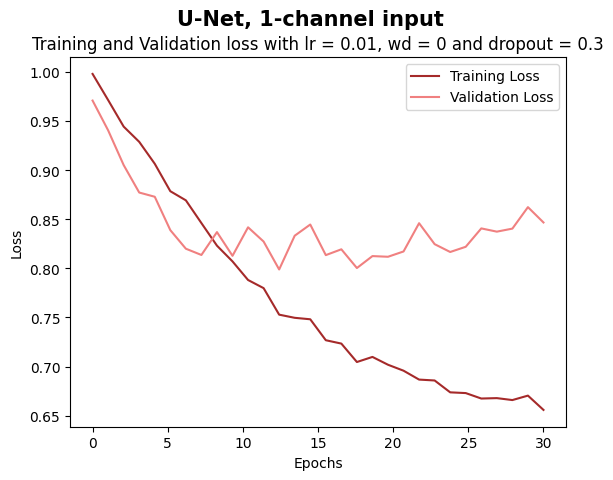


 Validation dice score = 0.15171389281749725


Epoch 1 | Training Loss: 0.9986 | Validation Loss: 0.9980
Epoch 2 | Training Loss: 0.9807 | Validation Loss: 0.9691
Epoch 3 | Training Loss: 0.9598 | Validation Loss: 0.9241
Epoch 4 | Training Loss: 0.9290 | Validation Loss: 0.9151
Epoch 5 | Training Loss: 0.8975 | Validation Loss: 0.8694
Epoch 6 | Training Loss: 0.8745 | Validation Loss: 0.8447
Epoch 7 | Training Loss: 0.8419 | Validation Loss: 0.8594
Epoch 8 | Training Loss: 0.8239 | Validation Loss: 0.8618
Epoch 9 | Training Loss: 0.8050 | Validation Loss: 0.8788
Epoch 10 | Training Loss: 0.7853 | Validation Loss: 0.8363
Epoch 11 | Training Loss: 0.7622 | Validation Loss: 0.8464
Epoch 12 | Training Loss: 0.7489 | Validation Loss: 0.8321
Epoch 13 | Training Loss: 0.7491 | Validation Loss: 0.8178
Epoch 14 | Training Loss: 0.7347 | Validation Loss: 0.8039
Epoch 15 | Training Loss: 0.7218 | Validation Loss: 0.8220
Epoch 16 | Training Loss: 0.7087 | Validation Loss: 0.8435
Epoch 17 | Traini

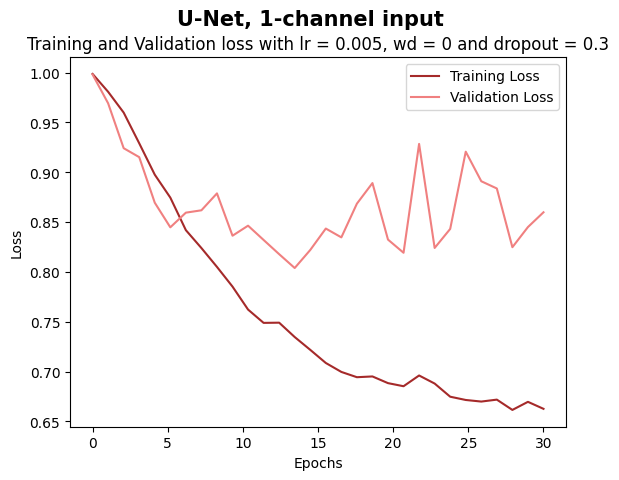


 Validation dice score = 0.1441836953163147


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9993
Epoch 2 | Training Loss: 0.9995 | Validation Loss: 0.9982
Epoch 3 | Training Loss: 0.9986 | Validation Loss: 0.9946
Epoch 4 | Training Loss: 0.9950 | Validation Loss: 0.9747
Epoch 5 | Training Loss: 0.9812 | Validation Loss: 0.9607
Epoch 6 | Training Loss: 0.9614 | Validation Loss: 0.9398
Epoch 7 | Training Loss: 0.9227 | Validation Loss: 0.9183
Epoch 8 | Training Loss: 0.8887 | Validation Loss: 0.8909
Epoch 9 | Training Loss: 0.8595 | Validation Loss: 0.8622
Epoch 10 | Training Loss: 0.8343 | Validation Loss: 0.8547
Epoch 11 | Training Loss: 0.8096 | Validation Loss: 0.8670
Epoch 12 | Training Loss: 0.7938 | Validation Loss: 0.8468
Epoch 13 | Training Loss: 0.7799 | Validation Loss: 0.8427
Epoch 14 | Training Loss: 0.7628 | Validation Loss: 0.8849
Epoch 15 | Training Loss: 0.7630 | Validation Loss: 0.8964
Epoch 16 | Training Loss: 0.7452 | Validation Loss: 0.8779
Epoch 17 | Trainin

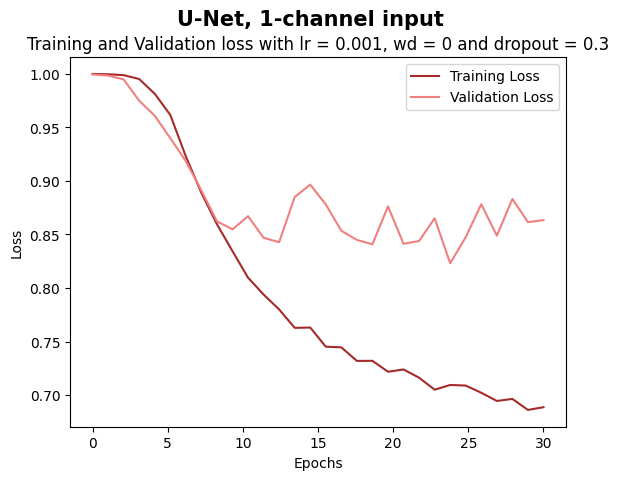


 Validation dice score = 0.1381044238805771


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9995
Epoch 2 | Training Loss: 0.9997 | Validation Loss: 0.9991
Epoch 3 | Training Loss: 0.9994 | Validation Loss: 0.9984
Epoch 4 | Training Loss: 0.9990 | Validation Loss: 0.9974
Epoch 5 | Training Loss: 0.9982 | Validation Loss: 0.9942
Epoch 6 | Training Loss: 0.9963 | Validation Loss: 0.9892
Epoch 7 | Training Loss: 0.9921 | Validation Loss: 0.9836
Epoch 8 | Training Loss: 0.9836 | Validation Loss: 0.9667
Epoch 9 | Training Loss: 0.9710 | Validation Loss: 0.9583
Epoch 10 | Training Loss: 0.9499 | Validation Loss: 0.9357
Epoch 11 | Training Loss: 0.9197 | Validation Loss: 0.9164
Epoch 12 | Training Loss: 0.8839 | Validation Loss: 0.9209
Epoch 13 | Training Loss: 0.8602 | Validation Loss: 0.8906
Epoch 14 | Training Loss: 0.8343 | Validation Loss: 0.9238
Epoch 15 | Training Loss: 0.8135 | Validation Loss: 0.9070
Epoch 16 | Training Loss: 0.7944 | Validation Loss: 0.8681
Epoch 17 | Trainin

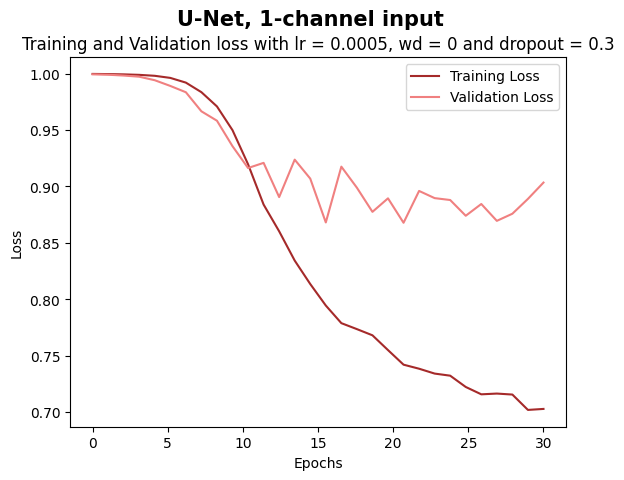


 Validation dice score = 0.09578685462474823


Epoch 1 | Training Loss: 0.9988 | Validation Loss: 0.9986
Epoch 2 | Training Loss: 0.9975 | Validation Loss: 0.9909
Epoch 3 | Training Loss: 0.9855 | Validation Loss: 0.9768
Epoch 4 | Training Loss: 0.9791 | Validation Loss: 0.9744
Epoch 5 | Training Loss: 0.9682 | Validation Loss: 1.0000
Epoch 6 | Training Loss: 1.0000 | Validation Loss: 0.9999
Epoch 7 | Training Loss: 0.9932 | Validation Loss: 1.0000
Epoch 8 | Training Loss: 0.9929 | Validation Loss: 0.9642
Epoch 9 | Training Loss: 0.9610 | Validation Loss: 1.0000
Epoch 10 | Training Loss: 0.9923 | Validation Loss: 0.9733
Epoch 11 | Training Loss: 0.9704 | Validation Loss: 0.9959
Epoch 12 | Training Loss: 0.9673 | Validation Loss: 0.9400
Epoch 13 | Training Loss: 0.9560 | Validation Loss: 0.9528
Epoch 14 | Training Loss: 0.9568 | Validation Loss: 0.9411
Epoch 15 | Training Loss: 0.9419 | Validation Loss: 0.9174
Epoch 16 | Training Loss: 0.9470 | Validation Loss: 0.9019
Epoch 17 | Traini

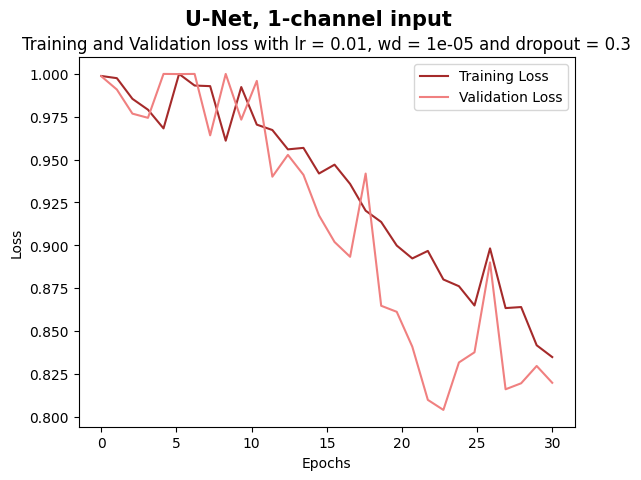


 Validation dice score = 0.21171574294567108


Epoch 1 | Training Loss: 0.9994 | Validation Loss: 0.9951
Epoch 2 | Training Loss: 0.9916 | Validation Loss: 0.9698
Epoch 3 | Training Loss: 0.9684 | Validation Loss: 0.9479
Epoch 4 | Training Loss: 0.9594 | Validation Loss: 0.9237
Epoch 5 | Training Loss: 0.9374 | Validation Loss: 0.9183
Epoch 6 | Training Loss: 0.9215 | Validation Loss: 0.8893
Epoch 7 | Training Loss: 0.9171 | Validation Loss: 0.8848
Epoch 8 | Training Loss: 0.9160 | Validation Loss: 0.8658
Epoch 9 | Training Loss: 0.8972 | Validation Loss: 0.8743
Epoch 10 | Training Loss: 0.8860 | Validation Loss: 0.8485
Epoch 11 | Training Loss: 0.8549 | Validation Loss: 0.8474
Epoch 12 | Training Loss: 0.8452 | Validation Loss: 0.8850
Epoch 13 | Training Loss: 0.8332 | Validation Loss: 0.8565
Epoch 14 | Training Loss: 0.8278 | Validation Loss: 0.8496
Epoch 15 | Training Loss: 0.8026 | Validation Loss: 0.8255
Epoch 16 | Training Loss: 0.7844 | Validation Loss: 0.8438
Epoch 17 | Traini

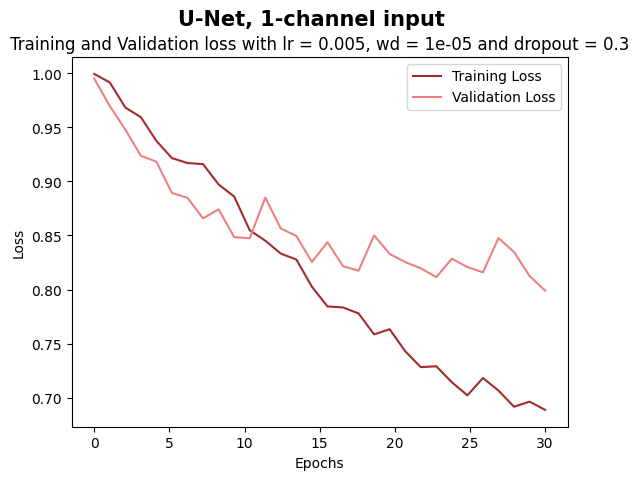


 Validation dice score = 0.24239236116409302


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9994
Epoch 2 | Training Loss: 0.9996 | Validation Loss: 0.9990
Epoch 3 | Training Loss: 0.9992 | Validation Loss: 0.9980
Epoch 4 | Training Loss: 0.9969 | Validation Loss: 0.9833
Epoch 5 | Training Loss: 0.9864 | Validation Loss: 0.9937
Epoch 6 | Training Loss: 0.9770 | Validation Loss: 0.9348
Epoch 7 | Training Loss: 0.9411 | Validation Loss: 0.8979
Epoch 8 | Training Loss: 0.9216 | Validation Loss: 0.9145
Epoch 9 | Training Loss: 0.8944 | Validation Loss: 0.8520
Epoch 10 | Training Loss: 0.8676 | Validation Loss: 0.8578
Epoch 11 | Training Loss: 0.8515 | Validation Loss: 0.8177
Epoch 12 | Training Loss: 0.8271 | Validation Loss: 0.8232
Epoch 13 | Training Loss: 0.8093 | Validation Loss: 0.8431
Epoch 14 | Training Loss: 0.8032 | Validation Loss: 0.8393
Epoch 15 | Training Loss: 0.7806 | Validation Loss: 0.8197
Epoch 16 | Training Loss: 0.7832 | Validation Loss: 0.8209
Epoch 17 | Traini

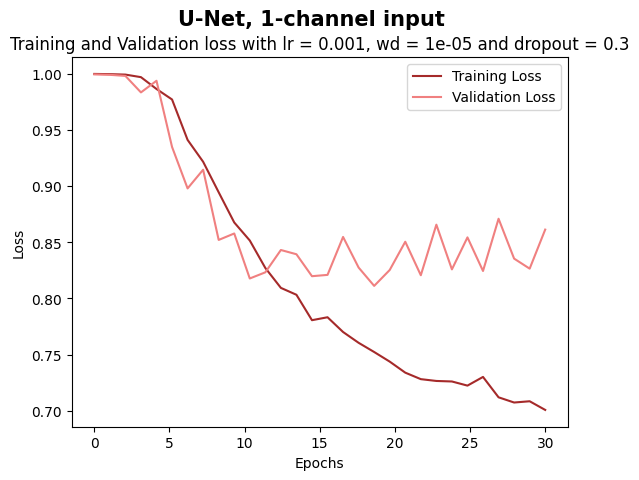


 Validation dice score = 0.1464962512254715


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9995
Epoch 2 | Training Loss: 0.9997 | Validation Loss: 0.9991
Epoch 3 | Training Loss: 0.9995 | Validation Loss: 0.9985
Epoch 4 | Training Loss: 0.9991 | Validation Loss: 0.9979
Epoch 5 | Training Loss: 0.9983 | Validation Loss: 0.9940
Epoch 6 | Training Loss: 0.9963 | Validation Loss: 0.9854
Epoch 7 | Training Loss: 0.9913 | Validation Loss: 0.9718
Epoch 8 | Training Loss: 0.9841 | Validation Loss: 0.9619
Epoch 9 | Training Loss: 0.9697 | Validation Loss: 0.9543
Epoch 10 | Training Loss: 0.9441 | Validation Loss: 0.9744
Epoch 11 | Training Loss: 0.9237 | Validation Loss: 0.9264
Epoch 12 | Training Loss: 0.8921 | Validation Loss: 0.9095
Epoch 13 | Training Loss: 0.8748 | Validation Loss: 0.8984
Epoch 14 | Training Loss: 0.8534 | Validation Loss: 0.8980
Epoch 15 | Training Loss: 0.8274 | Validation Loss: 0.8967
Epoch 16 | Training Loss: 0.8165 | Validation Loss: 0.8982
Epoch 17 | Trainin

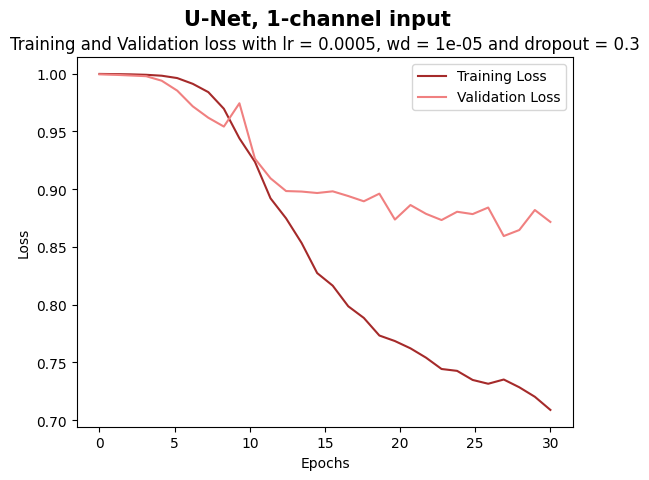


 Validation dice score = 0.14498081803321838


Epoch 1 | Training Loss: 0.9997 | Validation Loss: 0.9983
Epoch 2 | Training Loss: 0.9988 | Validation Loss: 0.9952
Epoch 3 | Training Loss: 0.9988 | Validation Loss: 0.9950
Epoch 4 | Training Loss: 0.9989 | Validation Loss: 0.9983
Epoch 5 | Training Loss: 0.9985 | Validation Loss: 0.9876
Epoch 6 | Training Loss: 0.9958 | Validation Loss: 0.9912
Epoch 7 | Training Loss: 0.9977 | Validation Loss: 0.9959
Epoch 8 | Training Loss: 0.9973 | Validation Loss: 0.9948
Epoch 9 | Training Loss: 0.9960 | Validation Loss: 0.9943
Epoch 10 | Training Loss: 0.9951 | Validation Loss: 0.9843
Epoch 11 | Training Loss: 0.9979 | Validation Loss: 0.9934
Epoch 12 | Training Loss: 0.9982 | Validation Loss: 0.9989
Epoch 13 | Training Loss: 0.9982 | Validation Loss: 0.9948
Epoch 14 | Training Loss: 0.9982 | Validation Loss: 0.9973
Epoch 15 | Training Loss: 0.9972 | Validation Loss: 0.9939
Epoch 16 | Training Loss: 0.9971 | Validation Loss: 0.9980
Epoch 17 | Traini

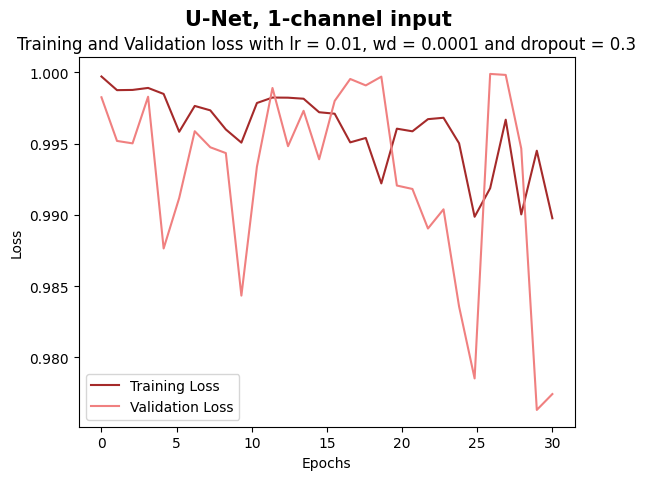


 Validation dice score = 0.03591393306851387


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9993
Epoch 2 | Training Loss: 0.9994 | Validation Loss: 0.9968
Epoch 3 | Training Loss: 0.9980 | Validation Loss: 0.9896
Epoch 4 | Training Loss: 0.9957 | Validation Loss: 0.9761
Epoch 5 | Training Loss: 0.9899 | Validation Loss: 0.9921
Epoch 6 | Training Loss: 0.9842 | Validation Loss: 0.9991
Epoch 7 | Training Loss: 0.9919 | Validation Loss: 0.9851
Epoch 8 | Training Loss: 0.9873 | Validation Loss: 1.0000
Epoch 9 | Training Loss: 0.9940 | Validation Loss: 0.9849
Epoch 10 | Training Loss: 0.9924 | Validation Loss: 0.9833
Epoch 11 | Training Loss: 0.9798 | Validation Loss: 0.9630
Epoch 12 | Training Loss: 0.9697 | Validation Loss: 0.9665
Epoch 13 | Training Loss: 0.9744 | Validation Loss: 0.9533
Epoch 14 | Training Loss: 0.9657 | Validation Loss: 0.9584
Epoch 15 | Training Loss: 0.9793 | Validation Loss: 0.9584
Epoch 16 | Training Loss: 0.9788 | Validation Loss: 0.9972
Epoch 17 | Traini

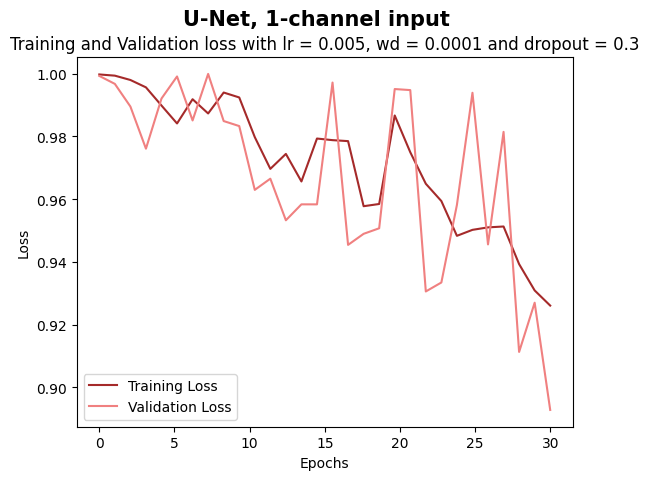


 Validation dice score = 0.10215036571025848


Epoch 1 | Training Loss: 0.9999 | Validation Loss: 0.9996
Epoch 2 | Training Loss: 0.9998 | Validation Loss: 0.9994
Epoch 3 | Training Loss: 0.9996 | Validation Loss: 0.9991
Epoch 4 | Training Loss: 0.9995 | Validation Loss: 0.9986
Epoch 5 | Training Loss: 0.9990 | Validation Loss: 0.9963
Epoch 6 | Training Loss: 0.9969 | Validation Loss: 0.9865
Epoch 7 | Training Loss: 0.9939 | Validation Loss: 0.9966
Epoch 8 | Training Loss: 0.9853 | Validation Loss: 0.9717
Epoch 9 | Training Loss: 0.9721 | Validation Loss: 0.9454
Epoch 10 | Training Loss: 0.9842 | Validation Loss: 1.0000
Epoch 11 | Training Loss: 0.9971 | Validation Loss: 0.9641
Epoch 12 | Training Loss: 0.9555 | Validation Loss: 0.9395
Epoch 13 | Training Loss: 0.9335 | Validation Loss: 0.9198
Epoch 14 | Training Loss: 0.9183 | Validation Loss: 0.9161
Epoch 15 | Training Loss: 0.9083 | Validation Loss: 0.8848
Epoch 16 | Training Loss: 0.8767 | Validation Loss: 0.8756
Epoch 17 | Traini

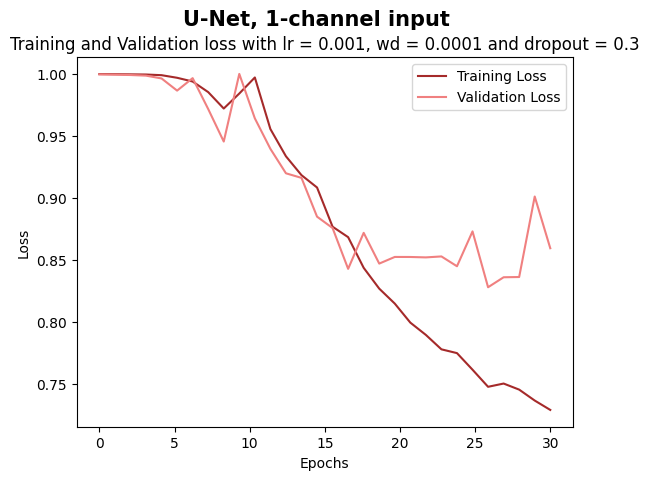


 Validation dice score = 0.15370599925518036


Epoch 1 | Training Loss: 0.9999 | Validation Loss: 0.9997
Epoch 2 | Training Loss: 0.9998 | Validation Loss: 0.9997
Epoch 3 | Training Loss: 0.9998 | Validation Loss: 0.9995
Epoch 4 | Training Loss: 0.9997 | Validation Loss: 0.9994
Epoch 5 | Training Loss: 0.9996 | Validation Loss: 0.9991
Epoch 6 | Training Loss: 0.9996 | Validation Loss: 0.9989
Epoch 7 | Training Loss: 0.9994 | Validation Loss: 0.9983
Epoch 8 | Training Loss: 0.9993 | Validation Loss: 0.9977
Epoch 9 | Training Loss: 0.9987 | Validation Loss: 0.9946
Epoch 10 | Training Loss: 0.9974 | Validation Loss: 0.9922
Epoch 11 | Training Loss: 0.9969 | Validation Loss: 0.9975
Epoch 12 | Training Loss: 0.9954 | Validation Loss: 0.9790
Epoch 13 | Training Loss: 0.9857 | Validation Loss: 0.9569
Epoch 14 | Training Loss: 0.9693 | Validation Loss: 0.9525
Epoch 15 | Training Loss: 0.9492 | Validation Loss: 0.9394
Epoch 16 | Training Loss: 0.9295 | Validation Loss: 0.9040
Epoch 17 | Traini

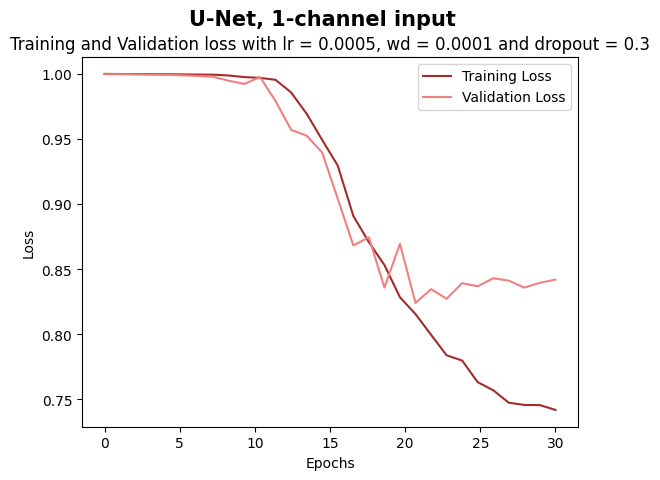


 Validation dice score = 0.20434845983982086


Epoch 1 | Training Loss: 0.9988 | Validation Loss: 0.9997
Epoch 2 | Training Loss: 0.9970 | Validation Loss: 0.9690
Epoch 3 | Training Loss: 0.9846 | Validation Loss: 0.9822
Epoch 4 | Training Loss: 0.9685 | Validation Loss: 0.9463
Epoch 5 | Training Loss: 0.9427 | Validation Loss: 0.9152
Epoch 6 | Training Loss: 0.9307 | Validation Loss: 0.9263
Epoch 7 | Training Loss: 0.9190 | Validation Loss: 0.8775
Epoch 8 | Training Loss: 0.9019 | Validation Loss: 0.8505
Epoch 9 | Training Loss: 0.8941 | Validation Loss: 0.8398
Epoch 10 | Training Loss: 0.8862 | Validation Loss: 0.8604
Epoch 11 | Training Loss: 0.8764 | Validation Loss: 0.8616
Epoch 12 | Training Loss: 0.8743 | Validation Loss: 0.8340
Epoch 13 | Training Loss: 0.8618 | Validation Loss: 0.8175
Epoch 14 | Training Loss: 0.8560 | Validation Loss: 0.8112
Epoch 15 | Training Loss: 0.8514 | Validation Loss: 0.8109
Epoch 16 | Training Loss: 0.8520 | Validation Loss: 0.8135
Epoch 17 | Traini

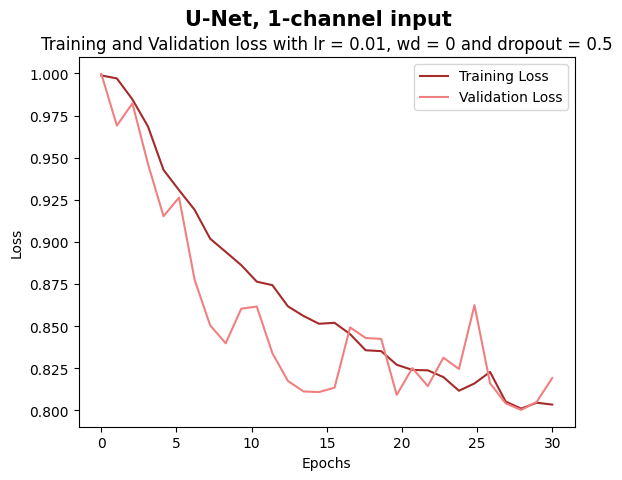


 Validation dice score = 0.20734071731567383


Epoch 1 | Training Loss: 0.9994 | Validation Loss: 0.9942
Epoch 2 | Training Loss: 0.9983 | Validation Loss: 0.9776
Epoch 3 | Training Loss: 0.9886 | Validation Loss: 0.9573
Epoch 4 | Training Loss: 0.9828 | Validation Loss: 0.9559
Epoch 5 | Training Loss: 0.9619 | Validation Loss: 0.9305
Epoch 6 | Training Loss: 0.9479 | Validation Loss: 0.9041
Epoch 7 | Training Loss: 0.9295 | Validation Loss: 0.9049
Epoch 8 | Training Loss: 0.9122 | Validation Loss: 0.8735
Epoch 9 | Training Loss: 0.9019 | Validation Loss: 0.8630
Epoch 10 | Training Loss: 0.8877 | Validation Loss: 0.8567
Epoch 11 | Training Loss: 0.8732 | Validation Loss: 0.8588
Epoch 12 | Training Loss: 0.8602 | Validation Loss: 0.8459
Epoch 13 | Training Loss: 0.8564 | Validation Loss: 0.8471
Epoch 14 | Training Loss: 0.8462 | Validation Loss: 0.8420
Epoch 15 | Training Loss: 0.8413 | Validation Loss: 0.8332
Epoch 16 | Training Loss: 0.8285 | Validation Loss: 0.8445
Epoch 17 | Traini

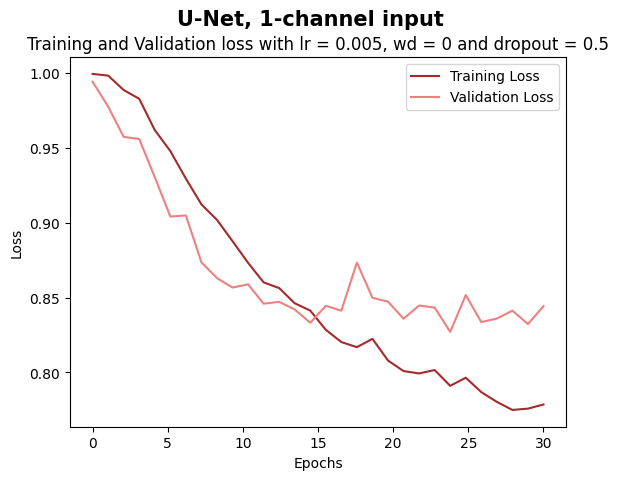


 Validation dice score = 0.15592843294143677


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9994
Epoch 2 | Training Loss: 0.9995 | Validation Loss: 0.9985
Epoch 3 | Training Loss: 0.9988 | Validation Loss: 0.9951
Epoch 4 | Training Loss: 0.9958 | Validation Loss: 0.9745
Epoch 5 | Training Loss: 0.9871 | Validation Loss: 0.9596
Epoch 6 | Training Loss: 0.9643 | Validation Loss: 0.9381
Epoch 7 | Training Loss: 0.9476 | Validation Loss: 0.9276
Epoch 8 | Training Loss: 0.9249 | Validation Loss: 0.8909
Epoch 9 | Training Loss: 0.9126 | Validation Loss: 0.8895
Epoch 10 | Training Loss: 0.8938 | Validation Loss: 0.8788
Epoch 11 | Training Loss: 0.8895 | Validation Loss: 0.8863
Epoch 12 | Training Loss: 0.8769 | Validation Loss: 0.8733
Epoch 13 | Training Loss: 0.8697 | Validation Loss: 0.8709
Epoch 14 | Training Loss: 0.8589 | Validation Loss: 0.8707
Epoch 15 | Training Loss: 0.8534 | Validation Loss: 0.8855
Epoch 16 | Training Loss: 0.8456 | Validation Loss: 0.8656
Epoch 17 | Traini

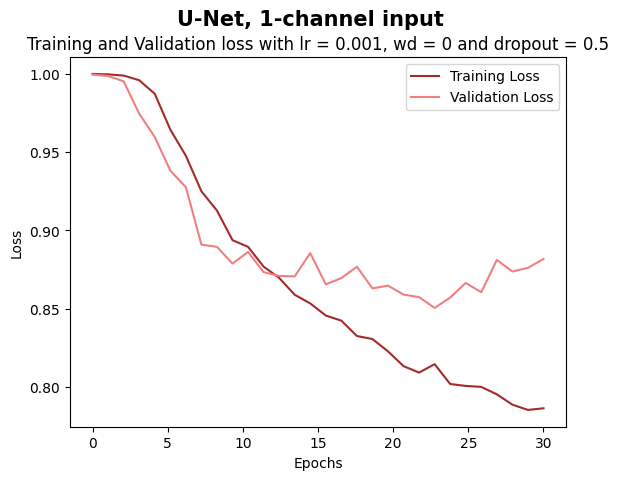


 Validation dice score = 0.1555333435535431


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9995
Epoch 2 | Training Loss: 0.9997 | Validation Loss: 0.9990
Epoch 3 | Training Loss: 0.9995 | Validation Loss: 0.9983
Epoch 4 | Training Loss: 0.9991 | Validation Loss: 0.9974
Epoch 5 | Training Loss: 0.9984 | Validation Loss: 0.9933
Epoch 6 | Training Loss: 0.9970 | Validation Loss: 0.9900
Epoch 7 | Training Loss: 0.9945 | Validation Loss: 0.9835
Epoch 8 | Training Loss: 0.9905 | Validation Loss: 0.9686
Epoch 9 | Training Loss: 0.9822 | Validation Loss: 0.9608
Epoch 10 | Training Loss: 0.9661 | Validation Loss: 0.9384
Epoch 11 | Training Loss: 0.9512 | Validation Loss: 0.9380
Epoch 12 | Training Loss: 0.9380 | Validation Loss: 0.9080
Epoch 13 | Training Loss: 0.9252 | Validation Loss: 0.9065
Epoch 14 | Training Loss: 0.9199 | Validation Loss: 0.9031
Epoch 15 | Training Loss: 0.9058 | Validation Loss: 0.8974
Epoch 16 | Training Loss: 0.8963 | Validation Loss: 0.9075
Epoch 17 | Trainin

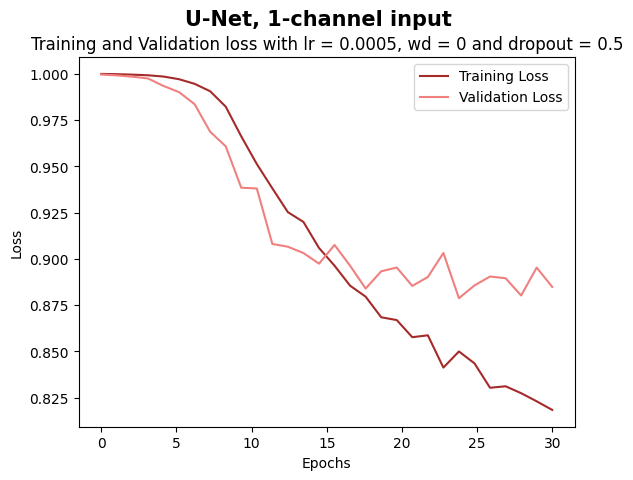


 Validation dice score = 0.14285960793495178


Epoch 1 | Training Loss: 0.9985 | Validation Loss: 0.9802
Epoch 2 | Training Loss: 0.9948 | Validation Loss: 0.9992
Epoch 3 | Training Loss: 0.9969 | Validation Loss: 0.9998
Epoch 4 | Training Loss: 0.9929 | Validation Loss: 0.9688
Epoch 5 | Training Loss: 0.9856 | Validation Loss: 0.9661
Epoch 6 | Training Loss: 0.9804 | Validation Loss: 0.9570
Epoch 7 | Training Loss: 0.9734 | Validation Loss: 0.9390
Epoch 8 | Training Loss: 0.9651 | Validation Loss: 0.9619
Epoch 9 | Training Loss: 0.9698 | Validation Loss: 0.9567
Epoch 10 | Training Loss: 0.9585 | Validation Loss: 0.9559
Epoch 11 | Training Loss: 0.9588 | Validation Loss: 1.0000
Epoch 12 | Training Loss: 1.0000 | Validation Loss: 1.0000
Epoch 13 | Training Loss: 0.9922 | Validation Loss: 0.9536
Epoch 14 | Training Loss: 0.9614 | Validation Loss: 0.9371
Epoch 15 | Training Loss: 0.9553 | Validation Loss: 0.9397
Epoch 16 | Training Loss: 0.9529 | Validation Loss: 0.9146
Epoch 17 | Traini

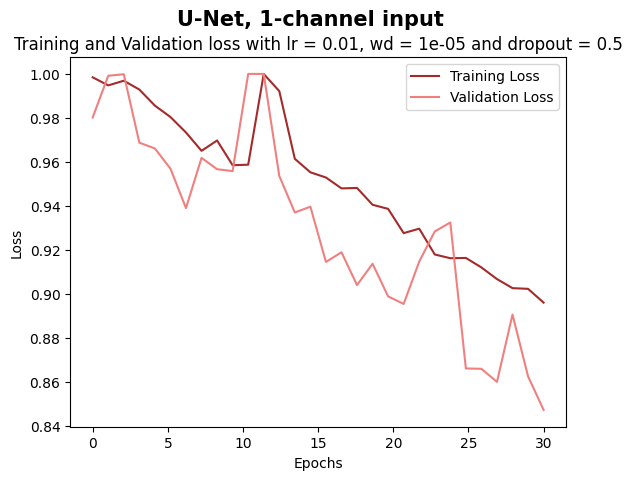


 Validation dice score = 0.16463027894496918


Epoch 1 | Training Loss: 0.9992 | Validation Loss: 0.9912
Epoch 2 | Training Loss: 0.9967 | Validation Loss: 0.9779
Epoch 3 | Training Loss: 0.9802 | Validation Loss: 0.9462
Epoch 4 | Training Loss: 0.9671 | Validation Loss: 0.9338
Epoch 5 | Training Loss: 0.9600 | Validation Loss: 0.9165
Epoch 6 | Training Loss: 0.9473 | Validation Loss: 0.9114
Epoch 7 | Training Loss: 0.9435 | Validation Loss: 0.9038
Epoch 8 | Training Loss: 0.9310 | Validation Loss: 0.9034
Epoch 9 | Training Loss: 0.9323 | Validation Loss: 0.8974
Epoch 10 | Training Loss: 0.9227 | Validation Loss: 0.8867
Epoch 11 | Training Loss: 0.9089 | Validation Loss: 0.8665
Epoch 12 | Training Loss: 0.8976 | Validation Loss: 0.8875
Epoch 13 | Training Loss: 0.8915 | Validation Loss: 0.8945
Epoch 14 | Training Loss: 0.8896 | Validation Loss: 0.8839
Epoch 15 | Training Loss: 0.8761 | Validation Loss: 0.8822
Epoch 16 | Training Loss: 0.8764 | Validation Loss: 0.8641
Epoch 17 | Traini

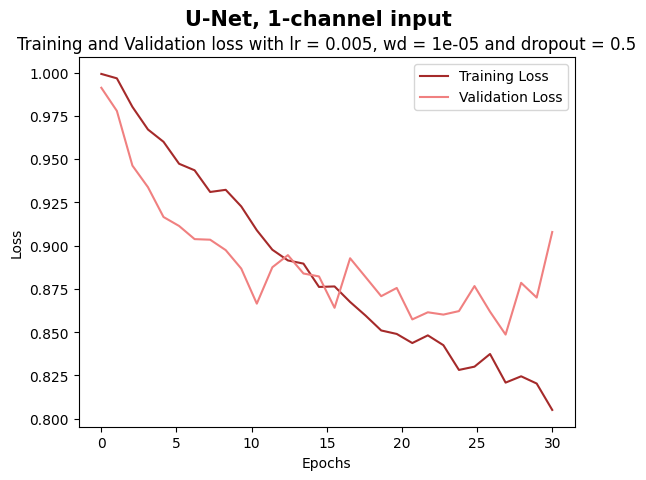


 Validation dice score = 0.08579418808221817


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9993
Epoch 2 | Training Loss: 0.9995 | Validation Loss: 0.9982
Epoch 3 | Training Loss: 0.9988 | Validation Loss: 0.9947
Epoch 4 | Training Loss: 0.9962 | Validation Loss: 0.9774
Epoch 5 | Training Loss: 0.9933 | Validation Loss: 0.9619
Epoch 6 | Training Loss: 0.9788 | Validation Loss: 0.9635
Epoch 7 | Training Loss: 0.9651 | Validation Loss: 0.9434
Epoch 8 | Training Loss: 0.9483 | Validation Loss: 0.9248
Epoch 9 | Training Loss: 0.9269 | Validation Loss: 0.9228
Epoch 10 | Training Loss: 0.9168 | Validation Loss: 0.9051
Epoch 11 | Training Loss: 0.8997 | Validation Loss: 0.8863
Epoch 12 | Training Loss: 0.8912 | Validation Loss: 0.8795
Epoch 13 | Training Loss: 0.8882 | Validation Loss: 0.8848
Epoch 14 | Training Loss: 0.8682 | Validation Loss: 0.8677
Epoch 15 | Training Loss: 0.8598 | Validation Loss: 0.8770
Epoch 16 | Training Loss: 0.8575 | Validation Loss: 0.8807
Epoch 17 | Traini

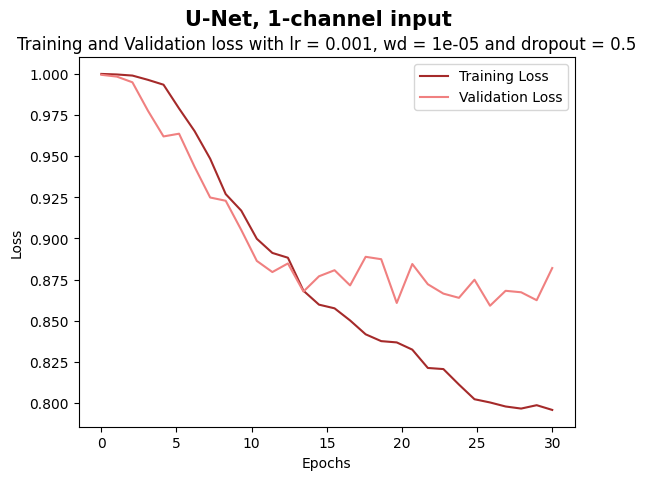


 Validation dice score = 0.1270044445991516


Epoch 1 | Training Loss: 0.9999 | Validation Loss: 0.9996
Epoch 2 | Training Loss: 0.9997 | Validation Loss: 0.9992
Epoch 3 | Training Loss: 0.9996 | Validation Loss: 0.9987
Epoch 4 | Training Loss: 0.9993 | Validation Loss: 0.9983
Epoch 5 | Training Loss: 0.9990 | Validation Loss: 0.9967
Epoch 6 | Training Loss: 0.9984 | Validation Loss: 0.9942
Epoch 7 | Training Loss: 0.9968 | Validation Loss: 0.9871
Epoch 8 | Training Loss: 0.9930 | Validation Loss: 0.9745
Epoch 9 | Training Loss: 0.9870 | Validation Loss: 0.9584
Epoch 10 | Training Loss: 0.9772 | Validation Loss: 0.9477
Epoch 11 | Training Loss: 0.9657 | Validation Loss: 0.9352
Epoch 12 | Training Loss: 0.9521 | Validation Loss: 0.9274
Epoch 13 | Training Loss: 0.9363 | Validation Loss: 0.9137
Epoch 14 | Training Loss: 0.9204 | Validation Loss: 0.8953
Epoch 15 | Training Loss: 0.9071 | Validation Loss: 0.9092
Epoch 16 | Training Loss: 0.8978 | Validation Loss: 0.8958
Epoch 17 | Trainin

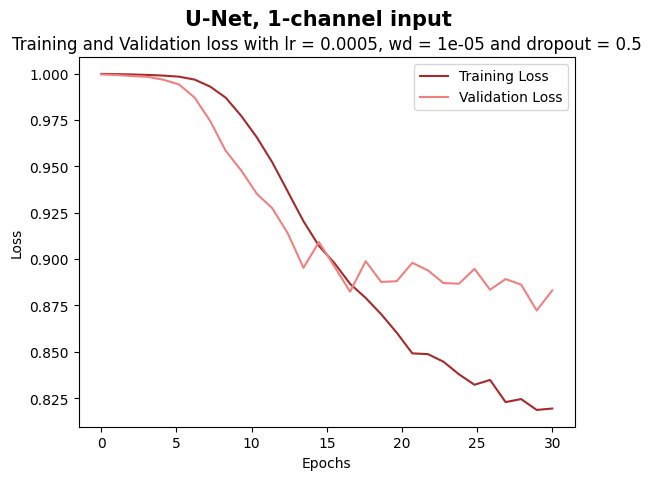


 Validation dice score = 0.14617545902729034


Epoch 1 | Training Loss: 0.9997 | Validation Loss: 0.9988
Epoch 2 | Training Loss: 0.9993 | Validation Loss: 0.9979
Epoch 3 | Training Loss: 0.9979 | Validation Loss: 0.9830
Epoch 4 | Training Loss: 0.9952 | Validation Loss: 0.9998
Epoch 5 | Training Loss: 0.9978 | Validation Loss: 0.9907
Epoch 6 | Training Loss: 0.9955 | Validation Loss: 0.9999
Epoch 7 | Training Loss: 0.9982 | Validation Loss: 0.9981
Epoch 8 | Training Loss: 0.9982 | Validation Loss: 0.9922
Epoch 9 | Training Loss: 0.9979 | Validation Loss: 0.9930
Epoch 10 | Training Loss: 0.9950 | Validation Loss: 0.9889
Epoch 11 | Training Loss: 0.9942 | Validation Loss: 0.9904
Epoch 12 | Training Loss: 0.9957 | Validation Loss: 0.9722
Epoch 13 | Training Loss: 0.9929 | Validation Loss: 0.9939
Epoch 14 | Training Loss: 0.9964 | Validation Loss: 0.9788
Epoch 15 | Training Loss: 0.9968 | Validation Loss: 0.9999
Epoch 16 | Training Loss: 0.9925 | Validation Loss: 0.9869
Epoch 17 | Traini

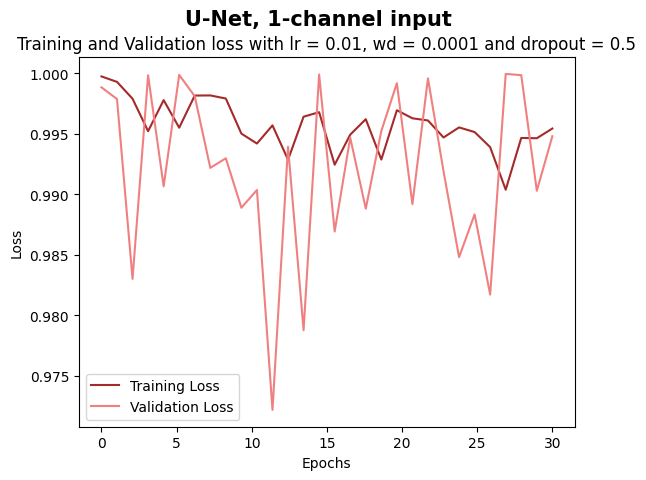


 Validation dice score = 0.005201973486691713


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9994
Epoch 2 | Training Loss: 0.9995 | Validation Loss: 0.9978
Epoch 3 | Training Loss: 0.9988 | Validation Loss: 0.9940
Epoch 4 | Training Loss: 0.9963 | Validation Loss: 0.9788
Epoch 5 | Training Loss: 0.9920 | Validation Loss: 0.9735
Epoch 6 | Training Loss: 0.9830 | Validation Loss: 0.9752
Epoch 7 | Training Loss: 0.9802 | Validation Loss: 0.9650
Epoch 8 | Training Loss: 0.9885 | Validation Loss: 0.9669
Epoch 9 | Training Loss: 0.9787 | Validation Loss: 0.9722
Epoch 10 | Training Loss: 0.9701 | Validation Loss: 0.9557
Epoch 11 | Training Loss: 0.9699 | Validation Loss: 0.9702
Epoch 12 | Training Loss: 0.9664 | Validation Loss: 0.9501
Epoch 13 | Training Loss: 0.9695 | Validation Loss: 1.0000
Epoch 14 | Training Loss: 0.9970 | Validation Loss: 0.9487
Epoch 15 | Training Loss: 0.9694 | Validation Loss: 0.9453
Epoch 16 | Training Loss: 0.9723 | Validation Loss: 0.9585
Epoch 17 | Train

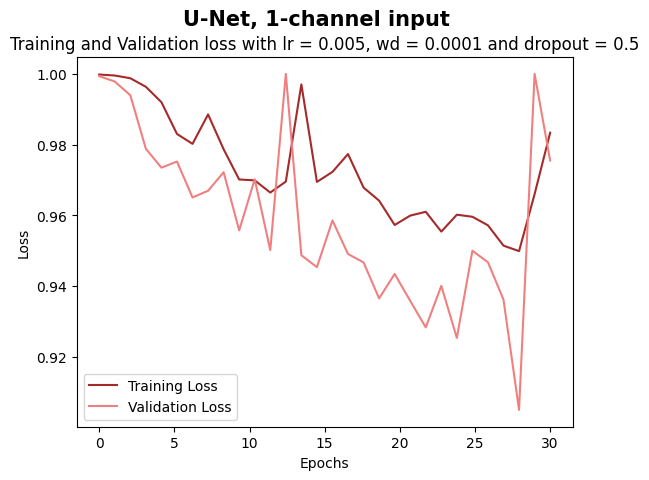


 Validation dice score = 0.023392461240291595


Epoch 1 | Training Loss: 0.9999 | Validation Loss: 0.9996
Epoch 2 | Training Loss: 0.9998 | Validation Loss: 0.9995
Epoch 3 | Training Loss: 0.9998 | Validation Loss: 0.9993
Epoch 4 | Training Loss: 0.9996 | Validation Loss: 0.9988
Epoch 5 | Training Loss: 0.9995 | Validation Loss: 0.9986
Epoch 6 | Training Loss: 0.9991 | Validation Loss: 0.9959
Epoch 7 | Training Loss: 0.9969 | Validation Loss: 0.9835
Epoch 8 | Training Loss: 0.9940 | Validation Loss: 0.9651
Epoch 9 | Training Loss: 0.9831 | Validation Loss: 0.9578
Epoch 10 | Training Loss: 0.9738 | Validation Loss: 0.9429
Epoch 11 | Training Loss: 0.9570 | Validation Loss: 0.9404
Epoch 12 | Training Loss: 0.9488 | Validation Loss: 0.9254
Epoch 13 | Training Loss: 0.9344 | Validation Loss: 0.9354
Epoch 14 | Training Loss: 0.9223 | Validation Loss: 0.9140
Epoch 15 | Training Loss: 0.9129 | Validation Loss: 0.9219
Epoch 16 | Training Loss: 0.9012 | Validation Loss: 0.9049
Epoch 17 | Train

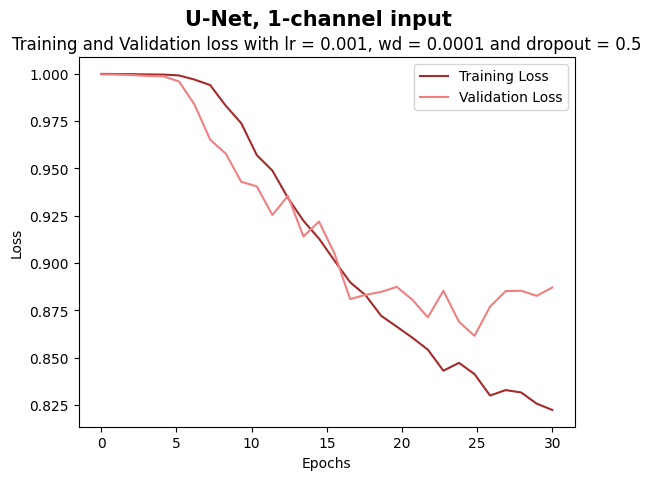


 Validation dice score = 0.12604986131191254


Epoch 1 | Training Loss: 0.9999 | Validation Loss: 0.9996
Epoch 2 | Training Loss: 0.9998 | Validation Loss: 0.9995
Epoch 3 | Training Loss: 0.9998 | Validation Loss: 0.9994
Epoch 4 | Training Loss: 0.9997 | Validation Loss: 0.9993
Epoch 5 | Training Loss: 0.9996 | Validation Loss: 0.9990
Epoch 6 | Training Loss: 0.9995 | Validation Loss: 0.9986
Epoch 7 | Training Loss: 0.9993 | Validation Loss: 0.9981
Epoch 8 | Training Loss: 0.9989 | Validation Loss: 0.9959
Epoch 9 | Training Loss: 0.9984 | Validation Loss: 0.9939
Epoch 10 | Training Loss: 0.9971 | Validation Loss: 0.9843
Epoch 11 | Training Loss: 0.9938 | Validation Loss: 0.9768
Epoch 12 | Training Loss: 0.9856 | Validation Loss: 0.9734
Epoch 13 | Training Loss: 0.9748 | Validation Loss: 0.9482
Epoch 14 | Training Loss: 0.9632 | Validation Loss: 0.9340
Epoch 15 | Training Loss: 0.9457 | Validation Loss: 0.9195
Epoch 16 | Training Loss: 0.9318 | Validation Loss: 0.9064
Epoch 17 | Traini

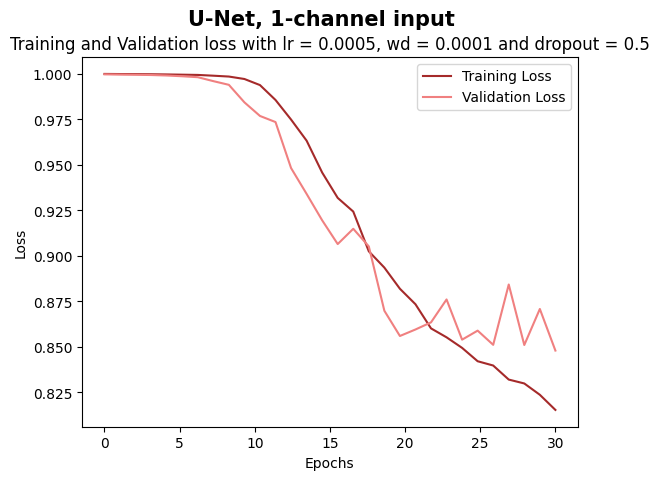


 Validation dice score = 0.17628392577171326




The model with the highest dice score has a score of 0.24239236116409302 and learning rate = 0.005, weight decay = 1e-05 and dropout = 0.3


In [12]:
# Hyperparameter values
lr_values = [0.01, 0.005, 0.001, 0.0005]
wd_values = [0, 1e-5, 1e-4]
dropout_values = [0.3, 0.5]

# Initializing the DCS value
best_dice = -np.inf

for do in dropout_values:
    for wd in wd_values:
        for lr in lr_values:
            
            # Model definition
            model = UNet(spatial_dims=3, in_channels=1, out_channels=1, channels=(16, 32, 64, 128, 256), strides=(2,2,2,2), dropout=do)

            device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
            model.to(device)

            # Defining the loss function, optimizer and number of iterations
            loss_fn = DiceLoss(sigmoid=True)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            n_epochs = 30
            x_values = np.linspace(0, n_epochs, n_epochs)
            
            # Train 1-channel model (lesion masks not used)
            train_loss, val_loss = train(n_epochs, 
                            optimizer, 
                            model, 
                            loss_fn, 
                            train_loader,
                            val_loader = val_loader)

            # Plotting the training and validation losses
            plot_losses(train_loss, val_loss, 'Validation', 1, lr, wd, do, x_values)

            # Computing the DSC on the validation data
            dice = evaluate_performance(model, val_loader)[0]
            print(f'\n Validation dice score = {dice}')
            print('\n')


            # Updating the dice score and hyperparameters for better models
            if dice > best_dice:
                best_dice = dice
                parameter1 = lr
                parameter2 = wd
                parameter3 = do
                best_model_1_channel = model

                     
print('\n')
print(f'The model with the highest dice score has a score of {best_dice} and learning rate = {parameter1}, weight decay = {parameter2} and dropout = {parameter3}')
               

### Model with two inputs

Epoch 1 | Training Loss: 0.8867 | Validation Loss: 0.7572
Epoch 2 | Training Loss: 0.7469 | Validation Loss: 0.7289
Epoch 3 | Training Loss: 0.7254 | Validation Loss: 0.7166
Epoch 4 | Training Loss: 0.7161 | Validation Loss: 0.7428
Epoch 5 | Training Loss: 0.7089 | Validation Loss: 0.7196
Epoch 6 | Training Loss: 0.7014 | Validation Loss: 0.7071
Epoch 7 | Training Loss: 0.7024 | Validation Loss: 0.6949
Epoch 8 | Training Loss: 0.6962 | Validation Loss: 0.6955
Epoch 9 | Training Loss: 0.6938 | Validation Loss: 0.6863
Epoch 10 | Training Loss: 0.6915 | Validation Loss: 0.6813
Epoch 11 | Training Loss: 0.6885 | Validation Loss: 0.6874
Epoch 12 | Training Loss: 0.6860 | Validation Loss: 0.6929
Epoch 13 | Training Loss: 0.6696 | Validation Loss: 0.6833
Epoch 14 | Training Loss: 0.6634 | Validation Loss: 0.6778
Epoch 15 | Training Loss: 0.6676 | Validation Loss: 0.7045
Epoch 16 | Training Loss: 0.6681 | Validation Loss: 0.6841
Epoch 17 | Training Loss: 0.6565 | Validation Loss: 0.6741
Epoch 

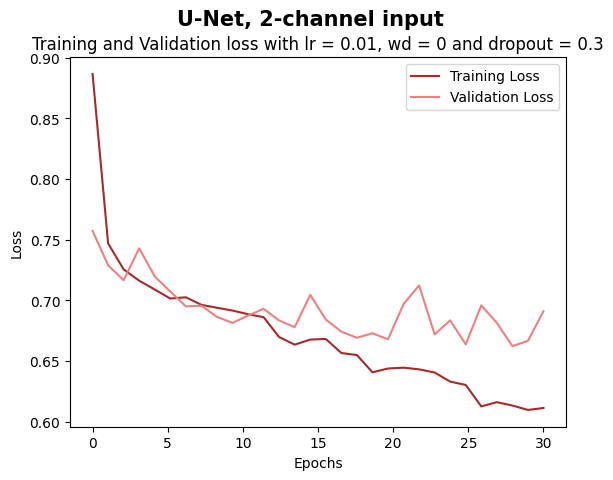


 Validation dice score = 0.35212773084640503


Epoch 1 | Training Loss: 0.9862 | Validation Loss: 0.8834
Epoch 2 | Training Loss: 0.7739 | Validation Loss: 0.7359
Epoch 3 | Training Loss: 0.7329 | Validation Loss: 0.7257
Epoch 4 | Training Loss: 0.7221 | Validation Loss: 0.7204
Epoch 5 | Training Loss: 0.7166 | Validation Loss: 0.6979
Epoch 6 | Training Loss: 0.7115 | Validation Loss: 0.7130
Epoch 7 | Training Loss: 0.7178 | Validation Loss: 0.7065
Epoch 8 | Training Loss: 0.6985 | Validation Loss: 0.7081
Epoch 9 | Training Loss: 0.6951 | Validation Loss: 0.6933
Epoch 10 | Training Loss: 0.6934 | Validation Loss: 0.6908
Epoch 11 | Training Loss: 0.6822 | Validation Loss: 0.6891
Epoch 12 | Training Loss: 0.6770 | Validation Loss: 0.6783
Epoch 13 | Training Loss: 0.6651 | Validation Loss: 0.6713
Epoch 14 | Training Loss: 0.6597 | Validation Loss: 0.6865
Epoch 15 | Training Loss: 0.6548 | Validation Loss: 0.6822
Epoch 16 | Training Loss: 0.6494 | Validation Loss: 0.6829
Epoch 17 | Traini

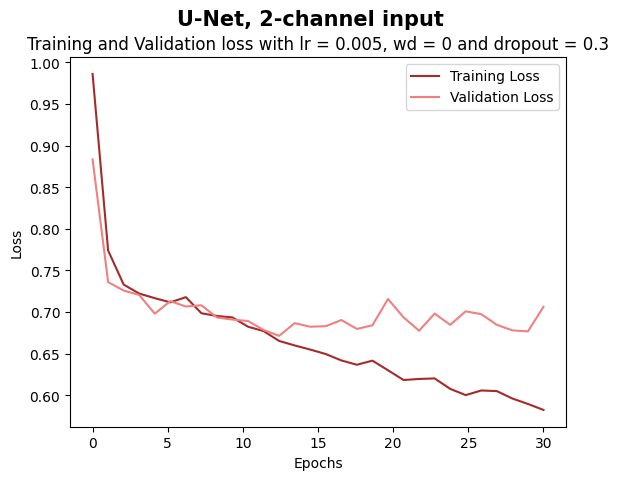


 Validation dice score = 0.32437455654144287


Epoch 1 | Training Loss: 0.9997 | Validation Loss: 0.9989
Epoch 2 | Training Loss: 0.9986 | Validation Loss: 0.9927
Epoch 3 | Training Loss: 0.9878 | Validation Loss: 0.9481
Epoch 4 | Training Loss: 0.9071 | Validation Loss: 0.7994
Epoch 5 | Training Loss: 0.7841 | Validation Loss: 0.7407
Epoch 6 | Training Loss: 0.7477 | Validation Loss: 0.7343
Epoch 7 | Training Loss: 0.7296 | Validation Loss: 0.7279
Epoch 8 | Training Loss: 0.7249 | Validation Loss: 0.7162
Epoch 9 | Training Loss: 0.7198 | Validation Loss: 0.7106
Epoch 10 | Training Loss: 0.7134 | Validation Loss: 0.7080
Epoch 11 | Training Loss: 0.7131 | Validation Loss: 0.7037
Epoch 12 | Training Loss: 0.7012 | Validation Loss: 0.7020
Epoch 13 | Training Loss: 0.6990 | Validation Loss: 0.6946
Epoch 14 | Training Loss: 0.6969 | Validation Loss: 0.7224
Epoch 15 | Training Loss: 0.6887 | Validation Loss: 0.6841
Epoch 16 | Training Loss: 0.6869 | Validation Loss: 0.6875
Epoch 17 | Traini

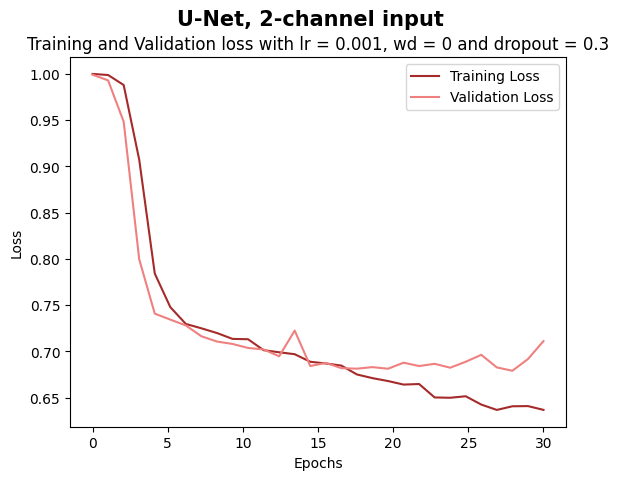


 Validation dice score = 0.32667016983032227


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9995
Epoch 2 | Training Loss: 0.9997 | Validation Loss: 0.9990
Epoch 3 | Training Loss: 0.9991 | Validation Loss: 0.9970
Epoch 4 | Training Loss: 0.9975 | Validation Loss: 0.9909
Epoch 5 | Training Loss: 0.9922 | Validation Loss: 0.9729
Epoch 6 | Training Loss: 0.9730 | Validation Loss: 0.9306
Epoch 7 | Training Loss: 0.9221 | Validation Loss: 0.8592
Epoch 8 | Training Loss: 0.8482 | Validation Loss: 0.7854
Epoch 9 | Training Loss: 0.7952 | Validation Loss: 0.7591
Epoch 10 | Training Loss: 0.7714 | Validation Loss: 0.7412
Epoch 11 | Training Loss: 0.7534 | Validation Loss: 0.7519
Epoch 12 | Training Loss: 0.7388 | Validation Loss: 0.7265
Epoch 13 | Training Loss: 0.7321 | Validation Loss: 0.7268
Epoch 14 | Training Loss: 0.7216 | Validation Loss: 0.7124
Epoch 15 | Training Loss: 0.7104 | Validation Loss: 0.7177
Epoch 16 | Training Loss: 0.6976 | Validation Loss: 0.7106
Epoch 17 | Traini

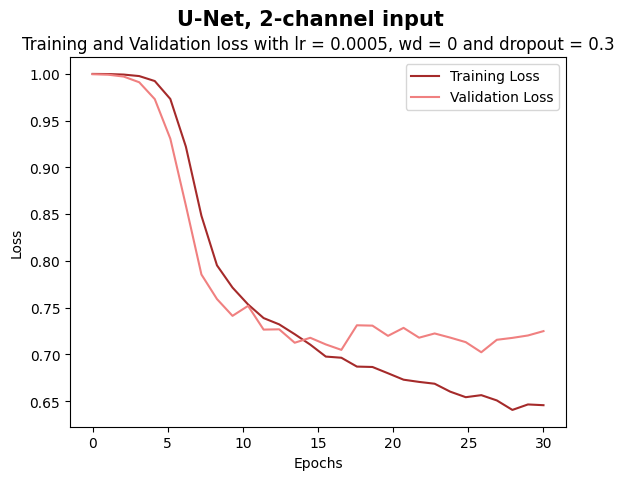


 Validation dice score = 0.33165308833122253


Epoch 1 | Training Loss: 0.9294 | Validation Loss: 0.7682
Epoch 2 | Training Loss: 0.7507 | Validation Loss: 0.7340
Epoch 3 | Training Loss: 0.7344 | Validation Loss: 0.7241
Epoch 4 | Training Loss: 0.7308 | Validation Loss: 0.7149
Epoch 5 | Training Loss: 0.7216 | Validation Loss: 0.7121
Epoch 6 | Training Loss: 0.7117 | Validation Loss: 0.7177
Epoch 7 | Training Loss: 0.7113 | Validation Loss: 0.7136
Epoch 8 | Training Loss: 0.7103 | Validation Loss: 0.7064
Epoch 9 | Training Loss: 0.7066 | Validation Loss: 0.6944
Epoch 10 | Training Loss: 0.7019 | Validation Loss: 0.7811
Epoch 11 | Training Loss: 0.7039 | Validation Loss: 0.6998
Epoch 12 | Training Loss: 0.7082 | Validation Loss: 0.6943
Epoch 13 | Training Loss: 0.6984 | Validation Loss: 0.6847
Epoch 14 | Training Loss: 0.6950 | Validation Loss: 0.6937
Epoch 15 | Training Loss: 0.7113 | Validation Loss: 0.6926
Epoch 16 | Training Loss: 0.6876 | Validation Loss: 0.6882
Epoch 17 | Traini

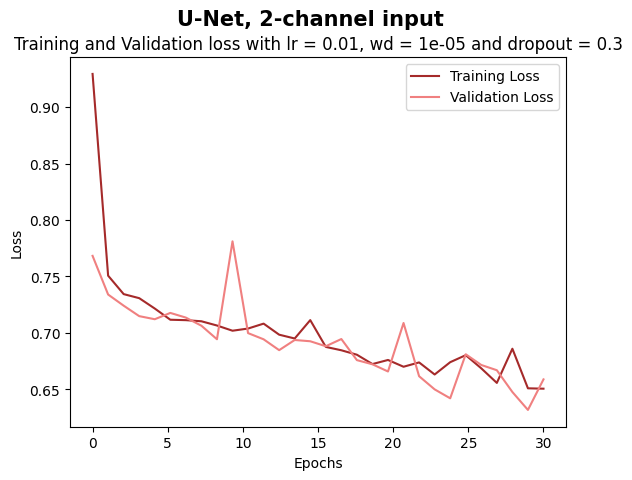


 Validation dice score = 0.36560067534446716


Epoch 1 | Training Loss: 0.9828 | Validation Loss: 0.8782
Epoch 2 | Training Loss: 0.7844 | Validation Loss: 0.7513
Epoch 3 | Training Loss: 0.7399 | Validation Loss: 0.7203
Epoch 4 | Training Loss: 0.7264 | Validation Loss: 0.7476
Epoch 5 | Training Loss: 0.7299 | Validation Loss: 0.7033
Epoch 6 | Training Loss: 0.7146 | Validation Loss: 0.7095
Epoch 7 | Training Loss: 0.7088 | Validation Loss: 0.7077
Epoch 8 | Training Loss: 0.7017 | Validation Loss: 0.7013
Epoch 9 | Training Loss: 0.7081 | Validation Loss: 0.7116
Epoch 10 | Training Loss: 0.6984 | Validation Loss: 0.6912
Epoch 11 | Training Loss: 0.6984 | Validation Loss: 0.7230
Epoch 12 | Training Loss: 0.6965 | Validation Loss: 0.6936
Epoch 13 | Training Loss: 0.6825 | Validation Loss: 0.6731
Epoch 14 | Training Loss: 0.6911 | Validation Loss: 0.7147
Epoch 15 | Training Loss: 0.6828 | Validation Loss: 0.6702
Epoch 16 | Training Loss: 0.6755 | Validation Loss: 0.6720
Epoch 17 | Traini

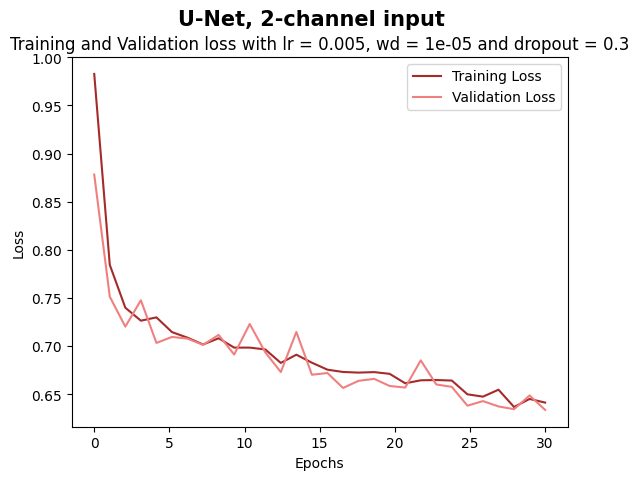


 Validation dice score = 0.40556100010871887


Epoch 1 | Training Loss: 0.9997 | Validation Loss: 0.9990
Epoch 2 | Training Loss: 0.9985 | Validation Loss: 0.9920
Epoch 3 | Training Loss: 0.9790 | Validation Loss: 0.9237
Epoch 4 | Training Loss: 0.8722 | Validation Loss: 0.7917
Epoch 5 | Training Loss: 0.7780 | Validation Loss: 0.7729
Epoch 6 | Training Loss: 0.7510 | Validation Loss: 0.7405
Epoch 7 | Training Loss: 0.7374 | Validation Loss: 0.7238
Epoch 8 | Training Loss: 0.7312 | Validation Loss: 0.7180
Epoch 9 | Training Loss: 0.7220 | Validation Loss: 0.7115
Epoch 10 | Training Loss: 0.7160 | Validation Loss: 0.7027
Epoch 11 | Training Loss: 0.7079 | Validation Loss: 0.6995
Epoch 12 | Training Loss: 0.7076 | Validation Loss: 0.7020
Epoch 13 | Training Loss: 0.6995 | Validation Loss: 0.6902
Epoch 14 | Training Loss: 0.6968 | Validation Loss: 0.6990
Epoch 15 | Training Loss: 0.6949 | Validation Loss: 0.6854
Epoch 16 | Training Loss: 0.6937 | Validation Loss: 0.6846
Epoch 17 | Traini

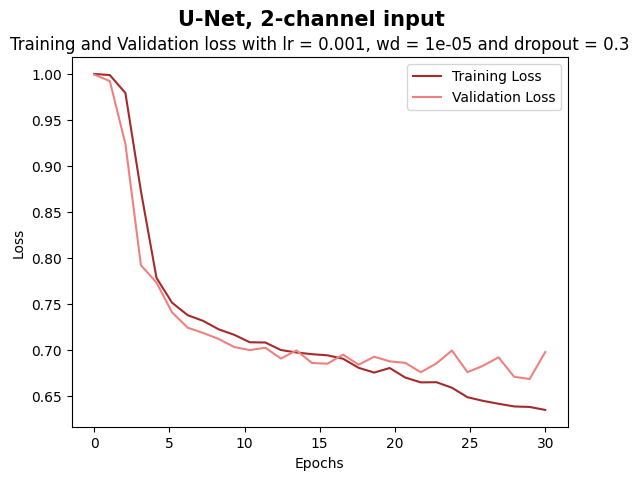


 Validation dice score = 0.3236769735813141


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9995
Epoch 2 | Training Loss: 0.9996 | Validation Loss: 0.9990
Epoch 3 | Training Loss: 0.9991 | Validation Loss: 0.9970
Epoch 4 | Training Loss: 0.9973 | Validation Loss: 0.9907
Epoch 5 | Training Loss: 0.9909 | Validation Loss: 0.9704
Epoch 6 | Training Loss: 0.9717 | Validation Loss: 0.9311
Epoch 7 | Training Loss: 0.9271 | Validation Loss: 0.8719
Epoch 8 | Training Loss: 0.8629 | Validation Loss: 0.7997
Epoch 9 | Training Loss: 0.8120 | Validation Loss: 0.7611
Epoch 10 | Training Loss: 0.7779 | Validation Loss: 0.7403
Epoch 11 | Training Loss: 0.7591 | Validation Loss: 0.7303
Epoch 12 | Training Loss: 0.7430 | Validation Loss: 0.7289
Epoch 13 | Training Loss: 0.7353 | Validation Loss: 0.7396
Epoch 14 | Training Loss: 0.7320 | Validation Loss: 0.7250
Epoch 15 | Training Loss: 0.7251 | Validation Loss: 0.7132
Epoch 16 | Training Loss: 0.7176 | Validation Loss: 0.7097
Epoch 17 | Trainin

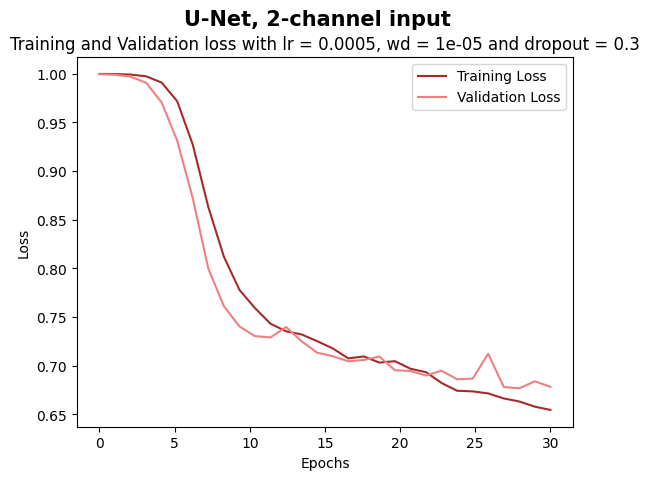


 Validation dice score = 0.40384188294410706


Epoch 1 | Training Loss: 0.9263 | Validation Loss: 0.7526
Epoch 2 | Training Loss: 0.7438 | Validation Loss: 0.7389
Epoch 3 | Training Loss: 0.7367 | Validation Loss: 0.7187
Epoch 4 | Training Loss: 0.7301 | Validation Loss: 0.7081
Epoch 5 | Training Loss: 0.7180 | Validation Loss: 0.7323
Epoch 6 | Training Loss: 0.7181 | Validation Loss: 0.7112
Epoch 7 | Training Loss: 0.7217 | Validation Loss: 0.7451
Epoch 8 | Training Loss: 0.7176 | Validation Loss: 0.7055
Epoch 9 | Training Loss: 0.7168 | Validation Loss: 0.7036
Epoch 10 | Training Loss: 0.7080 | Validation Loss: 0.7394
Epoch 11 | Training Loss: 0.7123 | Validation Loss: 0.7101
Epoch 12 | Training Loss: 0.7095 | Validation Loss: 0.7002
Epoch 13 | Training Loss: 0.7100 | Validation Loss: 0.6982
Epoch 14 | Training Loss: 0.7139 | Validation Loss: 0.7127
Epoch 15 | Training Loss: 0.7033 | Validation Loss: 0.7405
Epoch 16 | Training Loss: 0.7085 | Validation Loss: 0.7122
Epoch 17 | Traini

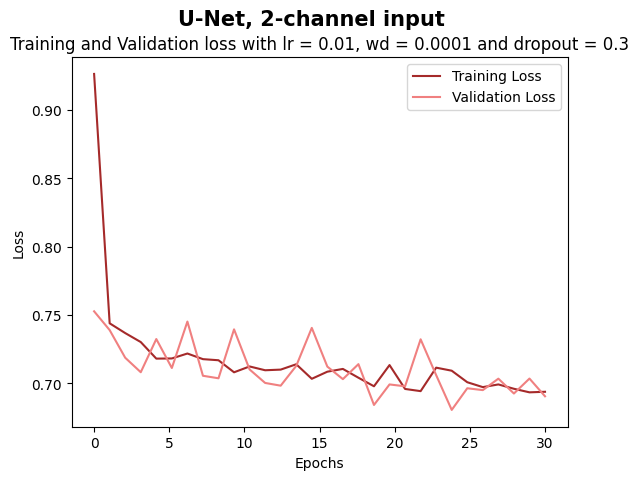


 Validation dice score = 0.3575023114681244


Epoch 1 | Training Loss: 0.9954 | Validation Loss: 0.9543
Epoch 2 | Training Loss: 0.8101 | Validation Loss: 0.7659
Epoch 3 | Training Loss: 0.7473 | Validation Loss: 0.7507
Epoch 4 | Training Loss: 0.7316 | Validation Loss: 0.7245
Epoch 5 | Training Loss: 0.7208 | Validation Loss: 0.7285
Epoch 6 | Training Loss: 0.7222 | Validation Loss: 0.7092
Epoch 7 | Training Loss: 0.7152 | Validation Loss: 0.7339
Epoch 8 | Training Loss: 0.7059 | Validation Loss: 0.7019
Epoch 9 | Training Loss: 0.7137 | Validation Loss: 0.7291
Epoch 10 | Training Loss: 0.7017 | Validation Loss: 0.6951
Epoch 11 | Training Loss: 0.7085 | Validation Loss: 0.7364
Epoch 12 | Training Loss: 0.7019 | Validation Loss: 0.7207
Epoch 13 | Training Loss: 0.7035 | Validation Loss: 0.6897
Epoch 14 | Training Loss: 0.6971 | Validation Loss: 0.6897
Epoch 15 | Training Loss: 0.6943 | Validation Loss: 0.7125
Epoch 16 | Training Loss: 0.6927 | Validation Loss: 0.7020
Epoch 17 | Trainin

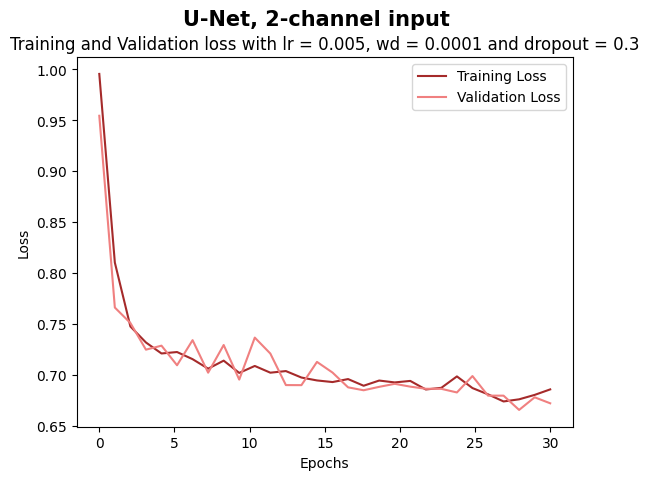


 Validation dice score = 0.35824090242385864


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9995
Epoch 2 | Training Loss: 0.9995 | Validation Loss: 0.9980
Epoch 3 | Training Loss: 0.9957 | Validation Loss: 0.9742
Epoch 4 | Training Loss: 0.9472 | Validation Loss: 0.8371
Epoch 5 | Training Loss: 0.8073 | Validation Loss: 0.7496
Epoch 6 | Training Loss: 0.7613 | Validation Loss: 0.7353
Epoch 7 | Training Loss: 0.7371 | Validation Loss: 0.7194
Epoch 8 | Training Loss: 0.7370 | Validation Loss: 0.7327
Epoch 9 | Training Loss: 0.7369 | Validation Loss: 0.7219
Epoch 10 | Training Loss: 0.7212 | Validation Loss: 0.7176
Epoch 11 | Training Loss: 0.7184 | Validation Loss: 0.7083
Epoch 12 | Training Loss: 0.7093 | Validation Loss: 0.6960
Epoch 13 | Training Loss: 0.7096 | Validation Loss: 0.6994
Epoch 14 | Training Loss: 0.6981 | Validation Loss: 0.6927
Epoch 15 | Training Loss: 0.6912 | Validation Loss: 0.6897
Epoch 16 | Training Loss: 0.6903 | Validation Loss: 0.7142
Epoch 17 | Traini

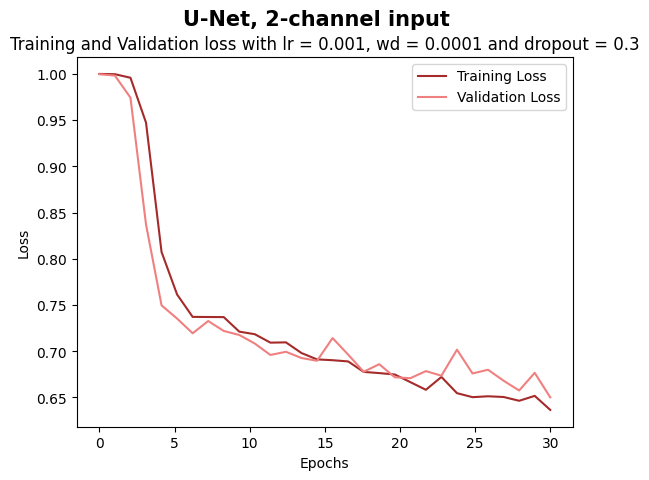


 Validation dice score = 0.4276182949542999


Epoch 1 | Training Loss: 0.9999 | Validation Loss: 0.9996
Epoch 2 | Training Loss: 0.9998 | Validation Loss: 0.9995
Epoch 3 | Training Loss: 0.9997 | Validation Loss: 0.9990
Epoch 4 | Training Loss: 0.9991 | Validation Loss: 0.9964
Epoch 5 | Training Loss: 0.9951 | Validation Loss: 0.9814
Epoch 6 | Training Loss: 0.9775 | Validation Loss: 0.9432
Epoch 7 | Training Loss: 0.9215 | Validation Loss: 0.8518
Epoch 8 | Training Loss: 0.8396 | Validation Loss: 0.7793
Epoch 9 | Training Loss: 0.7843 | Validation Loss: 0.7579
Epoch 10 | Training Loss: 0.7597 | Validation Loss: 0.7333
Epoch 11 | Training Loss: 0.7477 | Validation Loss: 0.7441
Epoch 12 | Training Loss: 0.7328 | Validation Loss: 0.7222
Epoch 13 | Training Loss: 0.7237 | Validation Loss: 0.7210
Epoch 14 | Training Loss: 0.7219 | Validation Loss: 0.7138
Epoch 15 | Training Loss: 0.7092 | Validation Loss: 0.7189
Epoch 16 | Training Loss: 0.7123 | Validation Loss: 0.7078
Epoch 17 | Trainin

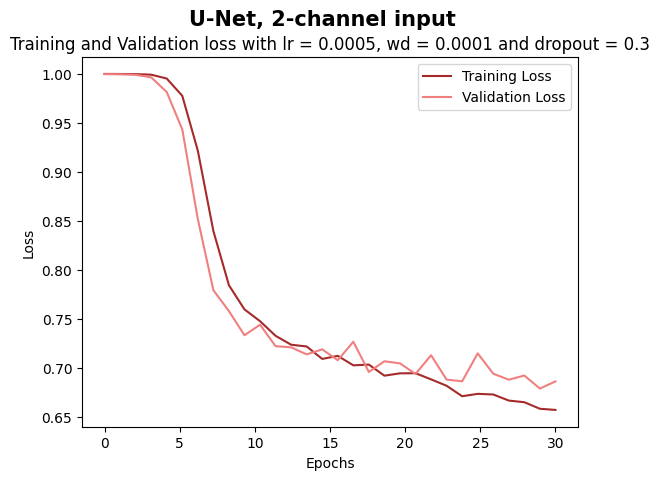


 Validation dice score = 0.3898894488811493


Epoch 1 | Training Loss: 0.9232 | Validation Loss: 0.7495
Epoch 2 | Training Loss: 0.7661 | Validation Loss: 0.7229
Epoch 3 | Training Loss: 0.7536 | Validation Loss: 0.7356
Epoch 4 | Training Loss: 0.7389 | Validation Loss: 0.7547
Epoch 5 | Training Loss: 0.7436 | Validation Loss: 0.7092
Epoch 6 | Training Loss: 0.7431 | Validation Loss: 0.7093
Epoch 7 | Training Loss: 0.7271 | Validation Loss: 0.7023
Epoch 8 | Training Loss: 0.7277 | Validation Loss: 0.7164
Epoch 9 | Training Loss: 0.7297 | Validation Loss: 0.7077
Epoch 10 | Training Loss: 0.7260 | Validation Loss: 0.7095
Epoch 11 | Training Loss: 0.7275 | Validation Loss: 0.7059
Epoch 12 | Training Loss: 0.7175 | Validation Loss: 0.7089
Epoch 13 | Training Loss: 0.7199 | Validation Loss: 0.7072
Epoch 14 | Training Loss: 0.7197 | Validation Loss: 0.7125
Epoch 15 | Training Loss: 0.7191 | Validation Loss: 0.6963
Epoch 16 | Training Loss: 0.7132 | Validation Loss: 0.7025
Epoch 17 | Trainin

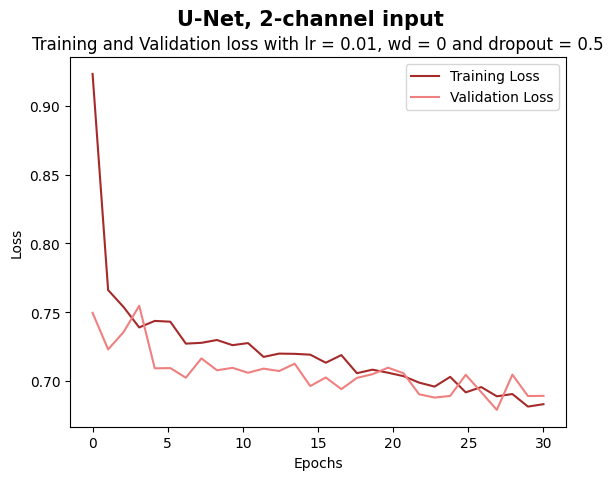


 Validation dice score = 0.36693617701530457


Epoch 1 | Training Loss: 0.9904 | Validation Loss: 0.9055
Epoch 2 | Training Loss: 0.8206 | Validation Loss: 0.8047
Epoch 3 | Training Loss: 0.7824 | Validation Loss: 0.7815
Epoch 4 | Training Loss: 0.7542 | Validation Loss: 0.7502
Epoch 5 | Training Loss: 0.7524 | Validation Loss: 0.7301
Epoch 6 | Training Loss: 0.7490 | Validation Loss: 0.7309
Epoch 7 | Training Loss: 0.7396 | Validation Loss: 0.7532
Epoch 8 | Training Loss: 0.7314 | Validation Loss: 0.7296
Epoch 9 | Training Loss: 0.7349 | Validation Loss: 0.7355
Epoch 10 | Training Loss: 0.7371 | Validation Loss: 0.7317
Epoch 11 | Training Loss: 0.7279 | Validation Loss: 0.7249
Epoch 12 | Training Loss: 0.7211 | Validation Loss: 0.7232
Epoch 13 | Training Loss: 0.7151 | Validation Loss: 0.7362
Epoch 14 | Training Loss: 0.7167 | Validation Loss: 0.7145
Epoch 15 | Training Loss: 0.7080 | Validation Loss: 0.7173
Epoch 16 | Training Loss: 0.7216 | Validation Loss: 0.7106
Epoch 17 | Traini

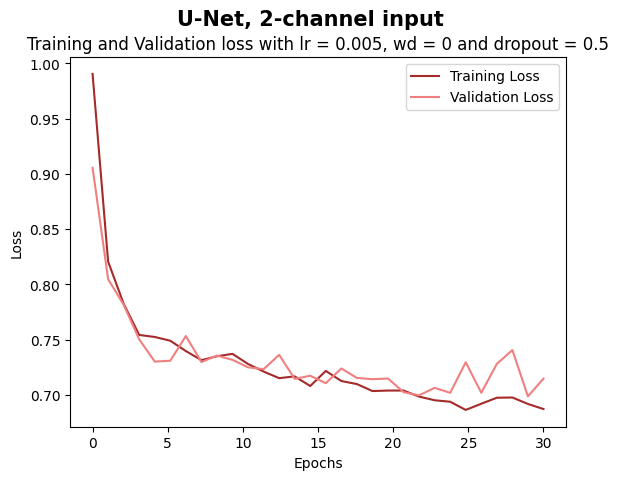


 Validation dice score = 0.36809560656547546


Epoch 1 | Training Loss: 0.9997 | Validation Loss: 0.9989
Epoch 2 | Training Loss: 0.9988 | Validation Loss: 0.9932
Epoch 3 | Training Loss: 0.9880 | Validation Loss: 0.9373
Epoch 4 | Training Loss: 0.9230 | Validation Loss: 0.8114
Epoch 5 | Training Loss: 0.8306 | Validation Loss: 0.7603
Epoch 6 | Training Loss: 0.7838 | Validation Loss: 0.7415
Epoch 7 | Training Loss: 0.7696 | Validation Loss: 0.7346
Epoch 8 | Training Loss: 0.7559 | Validation Loss: 0.7333
Epoch 9 | Training Loss: 0.7443 | Validation Loss: 0.7335
Epoch 10 | Training Loss: 0.7438 | Validation Loss: 0.7353
Epoch 11 | Training Loss: 0.7401 | Validation Loss: 0.7281
Epoch 12 | Training Loss: 0.7338 | Validation Loss: 0.7086
Epoch 13 | Training Loss: 0.7316 | Validation Loss: 0.7206
Epoch 14 | Training Loss: 0.7266 | Validation Loss: 0.7089
Epoch 15 | Training Loss: 0.7287 | Validation Loss: 0.7192
Epoch 16 | Training Loss: 0.7189 | Validation Loss: 0.7040
Epoch 17 | Traini

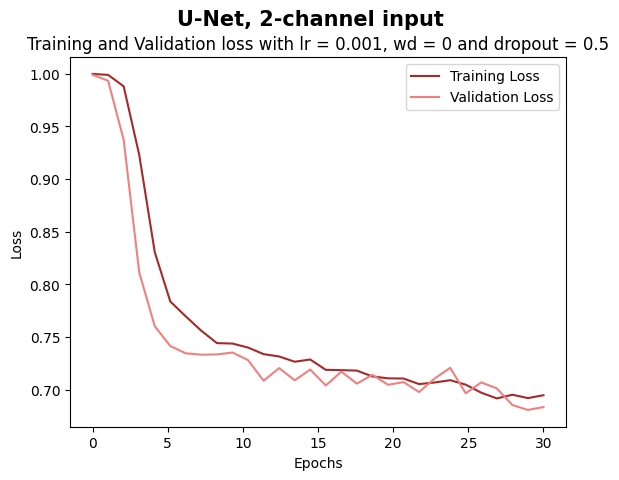


 Validation dice score = 0.37436553835868835


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9995
Epoch 2 | Training Loss: 0.9997 | Validation Loss: 0.9989
Epoch 3 | Training Loss: 0.9992 | Validation Loss: 0.9967
Epoch 4 | Training Loss: 0.9974 | Validation Loss: 0.9889
Epoch 5 | Training Loss: 0.9922 | Validation Loss: 0.9681
Epoch 6 | Training Loss: 0.9765 | Validation Loss: 0.9267
Epoch 7 | Training Loss: 0.9402 | Validation Loss: 0.8704
Epoch 8 | Training Loss: 0.8830 | Validation Loss: 0.7972
Epoch 9 | Training Loss: 0.8327 | Validation Loss: 0.7641
Epoch 10 | Training Loss: 0.7993 | Validation Loss: 0.7522
Epoch 11 | Training Loss: 0.7804 | Validation Loss: 0.7452
Epoch 12 | Training Loss: 0.7654 | Validation Loss: 0.7308
Epoch 13 | Training Loss: 0.7602 | Validation Loss: 0.7259
Epoch 14 | Training Loss: 0.7529 | Validation Loss: 0.7328
Epoch 15 | Training Loss: 0.7460 | Validation Loss: 0.7300
Epoch 16 | Training Loss: 0.7385 | Validation Loss: 0.7268
Epoch 17 | Traini

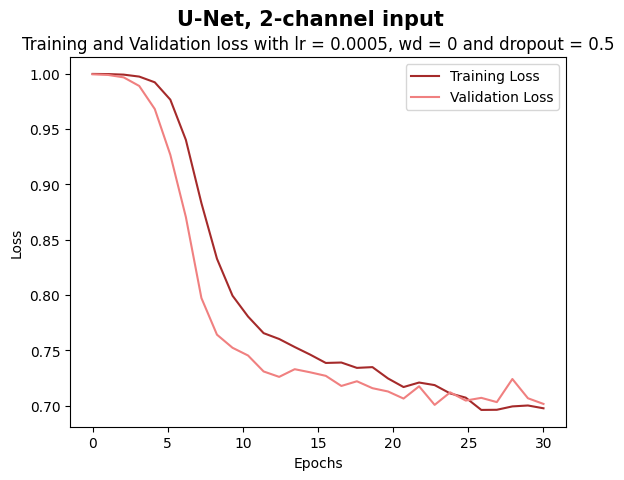


 Validation dice score = 0.37040120363235474


Epoch 1 | Training Loss: 0.9385 | Validation Loss: 0.7584
Epoch 2 | Training Loss: 0.7873 | Validation Loss: 0.7167
Epoch 3 | Training Loss: 0.7646 | Validation Loss: 0.7554
Epoch 4 | Training Loss: 0.7600 | Validation Loss: 0.7292
Epoch 5 | Training Loss: 0.7570 | Validation Loss: 0.7284
Epoch 6 | Training Loss: 0.7528 | Validation Loss: 0.7327
Epoch 7 | Training Loss: 0.7498 | Validation Loss: 0.7371
Epoch 8 | Training Loss: 0.7514 | Validation Loss: 0.7209
Epoch 9 | Training Loss: 0.7392 | Validation Loss: 0.7249
Epoch 10 | Training Loss: 0.7416 | Validation Loss: 0.7164
Epoch 11 | Training Loss: 0.7466 | Validation Loss: 0.7313
Epoch 12 | Training Loss: 0.7484 | Validation Loss: 0.7143
Epoch 13 | Training Loss: 0.7420 | Validation Loss: 0.7171
Epoch 14 | Training Loss: 0.7372 | Validation Loss: 0.7215
Epoch 15 | Training Loss: 0.7381 | Validation Loss: 0.7046
Epoch 16 | Training Loss: 0.7353 | Validation Loss: 0.7378
Epoch 17 | Traini

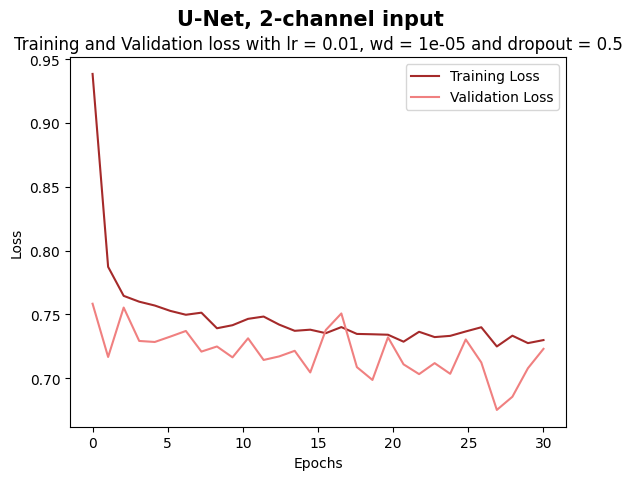


 Validation dice score = 0.3031970262527466


Epoch 1 | Training Loss: 0.9889 | Validation Loss: 0.9301
Epoch 2 | Training Loss: 0.8044 | Validation Loss: 0.7385
Epoch 3 | Training Loss: 0.7545 | Validation Loss: 0.7223
Epoch 4 | Training Loss: 0.7444 | Validation Loss: 0.7460
Epoch 5 | Training Loss: 0.7402 | Validation Loss: 0.7153
Epoch 6 | Training Loss: 0.7363 | Validation Loss: 0.7092
Epoch 7 | Training Loss: 0.7300 | Validation Loss: 0.6984
Epoch 8 | Training Loss: 0.7312 | Validation Loss: 0.7044
Epoch 9 | Training Loss: 0.7217 | Validation Loss: 0.7142
Epoch 10 | Training Loss: 0.7276 | Validation Loss: 0.7022
Epoch 11 | Training Loss: 0.7199 | Validation Loss: 0.7197
Epoch 12 | Training Loss: 0.7153 | Validation Loss: 0.6997
Epoch 13 | Training Loss: 0.7150 | Validation Loss: 0.6921
Epoch 14 | Training Loss: 0.7190 | Validation Loss: 0.7132
Epoch 15 | Training Loss: 0.7143 | Validation Loss: 0.6951
Epoch 16 | Training Loss: 0.7195 | Validation Loss: 0.6885
Epoch 17 | Trainin

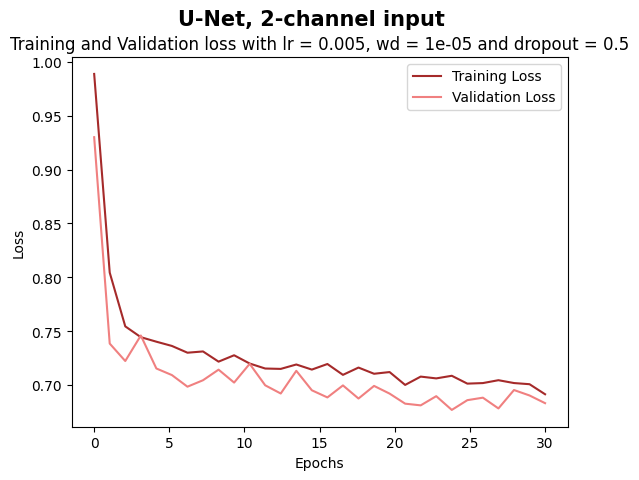


 Validation dice score = 0.4030967056751251


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9993
Epoch 2 | Training Loss: 0.9993 | Validation Loss: 0.9962
Epoch 3 | Training Loss: 0.9947 | Validation Loss: 0.9708
Epoch 4 | Training Loss: 0.9676 | Validation Loss: 0.8966
Epoch 5 | Training Loss: 0.8944 | Validation Loss: 0.7906
Epoch 6 | Training Loss: 0.8188 | Validation Loss: 0.7465
Epoch 7 | Training Loss: 0.7937 | Validation Loss: 0.7301
Epoch 8 | Training Loss: 0.7738 | Validation Loss: 0.7609
Epoch 9 | Training Loss: 0.7669 | Validation Loss: 0.7634
Epoch 10 | Training Loss: 0.7558 | Validation Loss: 0.7201
Epoch 11 | Training Loss: 0.7502 | Validation Loss: 0.7180
Epoch 12 | Training Loss: 0.7459 | Validation Loss: 0.7141
Epoch 13 | Training Loss: 0.7404 | Validation Loss: 0.7135
Epoch 14 | Training Loss: 0.7329 | Validation Loss: 0.7142
Epoch 15 | Training Loss: 0.7242 | Validation Loss: 0.7165
Epoch 16 | Training Loss: 0.7273 | Validation Loss: 0.7091
Epoch 17 | Trainin

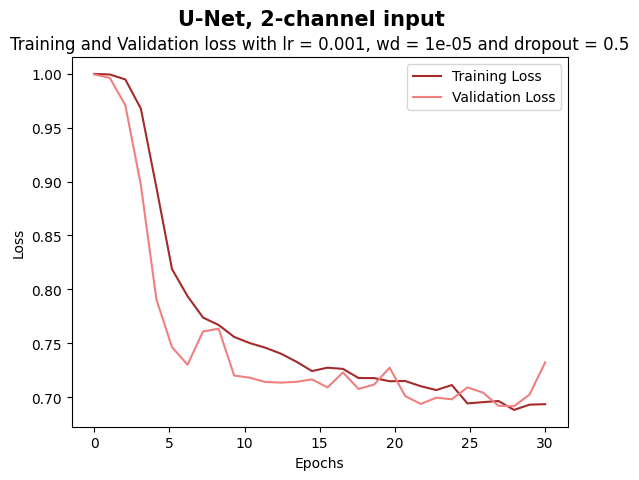


 Validation dice score = 0.3515867292881012


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9995
Epoch 2 | Training Loss: 0.9997 | Validation Loss: 0.9992
Epoch 3 | Training Loss: 0.9995 | Validation Loss: 0.9983
Epoch 4 | Training Loss: 0.9986 | Validation Loss: 0.9945
Epoch 5 | Training Loss: 0.9959 | Validation Loss: 0.9817
Epoch 6 | Training Loss: 0.9876 | Validation Loss: 0.9524
Epoch 7 | Training Loss: 0.9661 | Validation Loss: 0.9069
Epoch 8 | Training Loss: 0.9157 | Validation Loss: 0.8439
Epoch 9 | Training Loss: 0.8516 | Validation Loss: 0.7624
Epoch 10 | Training Loss: 0.8082 | Validation Loss: 0.7494
Epoch 11 | Training Loss: 0.7843 | Validation Loss: 0.7261
Epoch 12 | Training Loss: 0.7674 | Validation Loss: 0.7243
Epoch 13 | Training Loss: 0.7573 | Validation Loss: 0.7167
Epoch 14 | Training Loss: 0.7476 | Validation Loss: 0.7223
Epoch 15 | Training Loss: 0.7386 | Validation Loss: 0.7199
Epoch 16 | Training Loss: 0.7376 | Validation Loss: 0.7055
Epoch 17 | Trainin

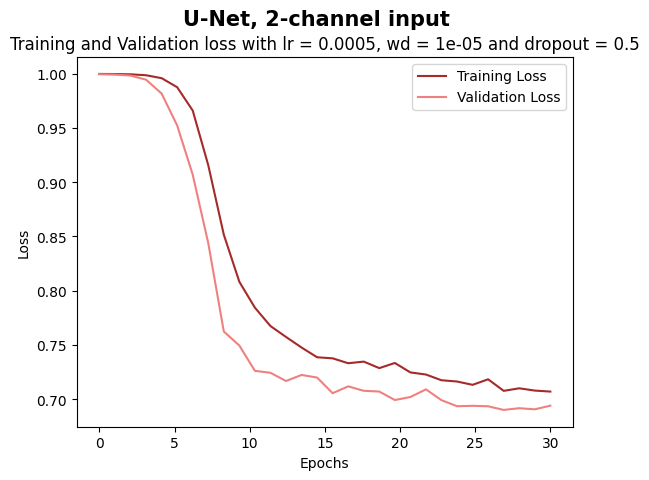


 Validation dice score = 0.397831529378891


Epoch 1 | Training Loss: 0.9288 | Validation Loss: 0.8002
Epoch 2 | Training Loss: 0.7949 | Validation Loss: 0.7693
Epoch 3 | Training Loss: 0.7778 | Validation Loss: 0.7579
Epoch 4 | Training Loss: 0.7706 | Validation Loss: 0.7550
Epoch 5 | Training Loss: 0.7690 | Validation Loss: 0.7670
Epoch 6 | Training Loss: 0.7641 | Validation Loss: 0.7577
Epoch 7 | Training Loss: 0.7620 | Validation Loss: 0.7429
Epoch 8 | Training Loss: 0.7557 | Validation Loss: 0.7520
Epoch 9 | Training Loss: 0.7546 | Validation Loss: 0.7365
Epoch 10 | Training Loss: 0.7492 | Validation Loss: 0.7733
Epoch 11 | Training Loss: 0.7493 | Validation Loss: 0.7684
Epoch 12 | Training Loss: 0.7470 | Validation Loss: 0.7238
Epoch 13 | Training Loss: 0.7447 | Validation Loss: 0.7303
Epoch 14 | Training Loss: 0.7427 | Validation Loss: 0.7256
Epoch 15 | Training Loss: 0.7414 | Validation Loss: 0.7416
Epoch 16 | Training Loss: 0.7488 | Validation Loss: 0.7275
Epoch 17 | Training

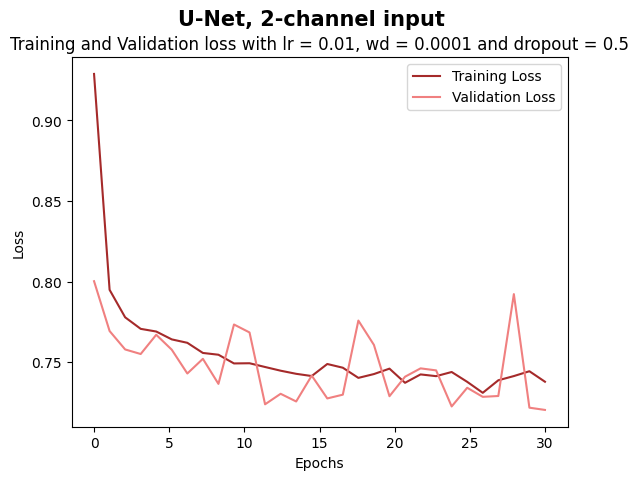


 Validation dice score = 0.3480304479598999


Epoch 1 | Training Loss: 0.9876 | Validation Loss: 0.8470
Epoch 2 | Training Loss: 0.7901 | Validation Loss: 0.7447
Epoch 3 | Training Loss: 0.7581 | Validation Loss: 0.7375
Epoch 4 | Training Loss: 0.7474 | Validation Loss: 0.7195
Epoch 5 | Training Loss: 0.7374 | Validation Loss: 0.7208
Epoch 6 | Training Loss: 0.7365 | Validation Loss: 0.7458
Epoch 7 | Training Loss: 0.7277 | Validation Loss: 0.7159
Epoch 8 | Training Loss: 0.7249 | Validation Loss: 0.7572
Epoch 9 | Training Loss: 0.7348 | Validation Loss: 0.7083
Epoch 10 | Training Loss: 0.7294 | Validation Loss: 0.7057
Epoch 11 | Training Loss: 0.7350 | Validation Loss: 0.7069
Epoch 12 | Training Loss: 0.7265 | Validation Loss: 0.7377
Epoch 13 | Training Loss: 0.7448 | Validation Loss: 0.7139
Epoch 14 | Training Loss: 0.7240 | Validation Loss: 0.7163
Epoch 15 | Training Loss: 0.7216 | Validation Loss: 0.7412
Epoch 16 | Training Loss: 0.7317 | Validation Loss: 0.7227
Epoch 17 | Trainin

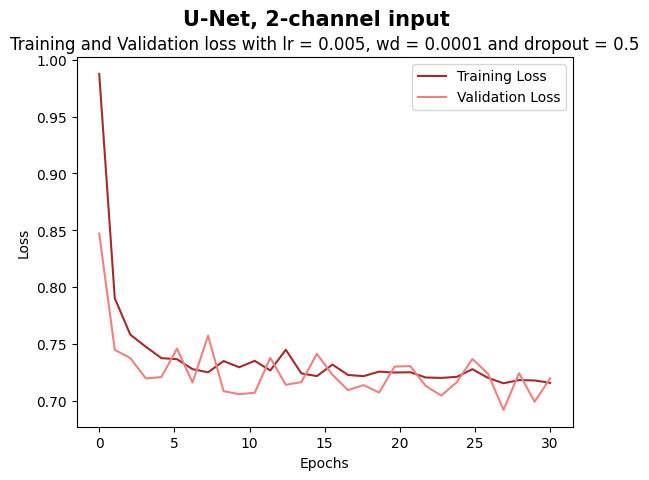


 Validation dice score = 0.3059596121311188


Epoch 1 | Training Loss: 0.9998 | Validation Loss: 0.9994
Epoch 2 | Training Loss: 0.9995 | Validation Loss: 0.9978
Epoch 3 | Training Loss: 0.9956 | Validation Loss: 0.9673
Epoch 4 | Training Loss: 0.9423 | Validation Loss: 0.8600
Epoch 5 | Training Loss: 0.8316 | Validation Loss: 0.7634
Epoch 6 | Training Loss: 0.7847 | Validation Loss: 0.7489
Epoch 7 | Training Loss: 0.7689 | Validation Loss: 0.7366
Epoch 8 | Training Loss: 0.7552 | Validation Loss: 0.7275
Epoch 9 | Training Loss: 0.7526 | Validation Loss: 0.7256
Epoch 10 | Training Loss: 0.7451 | Validation Loss: 0.7068
Epoch 11 | Training Loss: 0.7351 | Validation Loss: 0.7159
Epoch 12 | Training Loss: 0.7401 | Validation Loss: 0.7139
Epoch 13 | Training Loss: 0.7330 | Validation Loss: 0.7099
Epoch 14 | Training Loss: 0.7356 | Validation Loss: 0.6998
Epoch 15 | Training Loss: 0.7243 | Validation Loss: 0.7021
Epoch 16 | Training Loss: 0.7200 | Validation Loss: 0.6930
Epoch 17 | Trainin

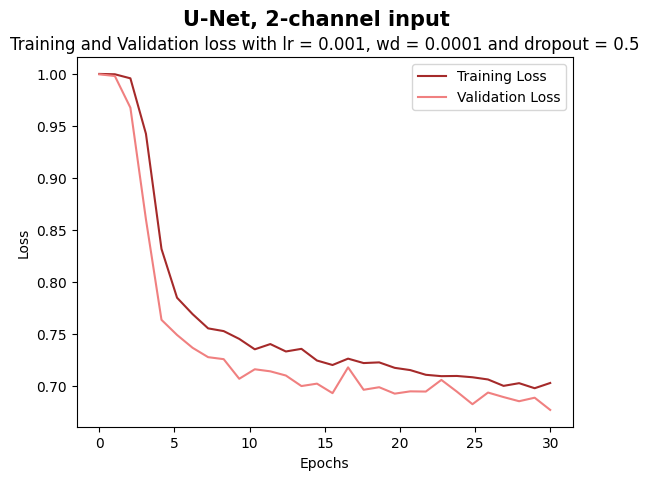


 Validation dice score = 0.37828823924064636


Epoch 1 | Training Loss: 0.9999 | Validation Loss: 0.9996
Epoch 2 | Training Loss: 0.9998 | Validation Loss: 0.9995
Epoch 3 | Training Loss: 0.9997 | Validation Loss: 0.9992
Epoch 4 | Training Loss: 0.9995 | Validation Loss: 0.9986
Epoch 5 | Training Loss: 0.9986 | Validation Loss: 0.9943
Epoch 6 | Training Loss: 0.9941 | Validation Loss: 0.9736
Epoch 7 | Training Loss: 0.9727 | Validation Loss: 0.9177
Epoch 8 | Training Loss: 0.9157 | Validation Loss: 0.8398
Epoch 9 | Training Loss: 0.8510 | Validation Loss: 0.7887
Epoch 10 | Training Loss: 0.8087 | Validation Loss: 0.7430
Epoch 11 | Training Loss: 0.7850 | Validation Loss: 0.7470
Epoch 12 | Training Loss: 0.7702 | Validation Loss: 0.7316
Epoch 13 | Training Loss: 0.7611 | Validation Loss: 0.7257
Epoch 14 | Training Loss: 0.7520 | Validation Loss: 0.7425
Epoch 15 | Training Loss: 0.7472 | Validation Loss: 0.7151
Epoch 16 | Training Loss: 0.7446 | Validation Loss: 0.7217
Epoch 17 | Traini

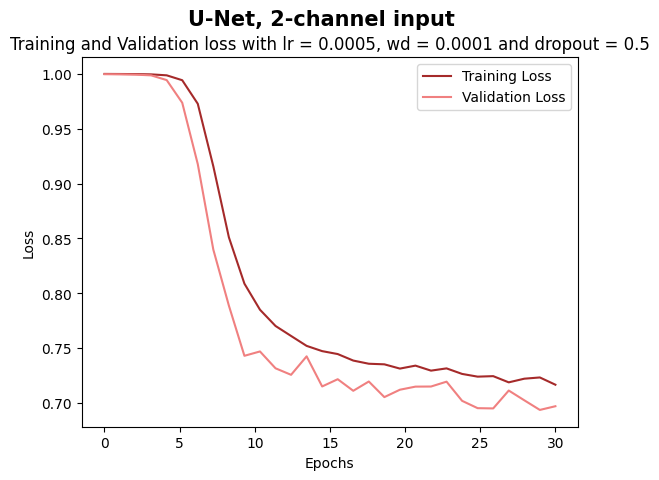


 Validation dice score = 0.35938185453414917




The model with the highest dice score has a score of 0.4276182949542999 and learning rate = 0.001, weight decay = 0.0001 and dropout = 0.3


In [16]:
# Hyperparameter values
lr_values = [0.01, 0.005, 0.001, 0.0005]
wd_values = [0, 1e-5, 1e-4]
dropout_values = [0.3, 0.5]


# Initializing the DCS value
best_dice = -np.inf

for do in dropout_values:
    for wd in wd_values:
        for lr in lr_values:

            # Model definition
            model = UNet(spatial_dims=3, in_channels=2, out_channels=1, channels=(16, 32, 64, 128, 256), strides=(2,2,2,2), dropout=do)

            # Defining the loss function, optimizer and number of iterations
            device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
            model.to(device)

            loss_fn = DiceLoss(sigmoid=True)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            n_epochs = 30
            x_values = np.linspace(0, n_epochs, n_epochs)
            
            # Train 2-channel model
            train_loss, val_loss = train(n_epochs, 
                            optimizer, 
                            model, 
                            loss_fn, 
                            train_dl,
                            les_mask = True,
                            val_loader = valid_dl)

            # Plotting the training and validation losses
            plot_losses(train_loss, val_loss, 'Validation', 2, lr, wd, do, x_values)


            # Computing the DSC on the validation data
            dice = evaluate_performance(model, valid_dl, les_mask=True)[0]
            print(f'\n Validation dice score = {dice}')
            print('\n')


            
            # Updating the dice score and hyperparameters for better models
            if dice > best_dice:
                best_dice = dice
                parameter1 = lr
                parameter2 = wd
                parameter3 = do
                best_model_2_channels = model

                     
print('\n')
print(f'The model with the highest dice score has a score of {best_dice} and learning rate = {parameter1}, weight decay = {parameter2} and dropout = {parameter3}')

### Saving the best models

In [29]:
# Saving the weights of the best models of both networks
torch.save(best_model_1_channel.state_dict(), "best_model_1_channel.pth")
torch.save(best_model_2_channels.state_dict(), "best_model_2_channels.pth")


## Loading the models

The trained models are reloaded from saved weights to ensure reproducibility and allow evaluation without re-running the training process. Both the one-channel and two-channel U-Net models are loaded from their respective best-performing checkpoints.

### Model with one input

In [15]:
# Setting the best-performing hyperparameters
do = 0.3
lr  = 0.005
wd = 1e-05

# Defining the model
model_1_channel = UNet(spatial_dims=3, in_channels=1, out_channels=1, channels=(16, 32, 64, 128, 256), strides=(2,2,2,2), dropout=do)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model_1_channel.to(device)

# Loading the saved model weights
model_1_channel.load_state_dict(torch.load("best_model_1_channel.pth", map_location="cuda"))
model_1_channel.eval()

print("Best model with one input loaded")

Best model with one input loaded


### Model with two inputs

In [16]:
# Setting the best-performing hyperparameters
do=0.3
lr  = 0.001
wd = 0.0001

# Defining the model
model_2_channel = UNet(spatial_dims=3, in_channels=2, out_channels=1, channels=(16, 32, 64, 128, 256), strides=(2,2,2,2), dropout=do)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model_2_channel.to(device)

# Loading the saved model weights
model_2_channel.load_state_dict(torch.load("best_model_2_channels.pth", map_location="cuda"))
model_2_channel.eval()

print("Best model with two inputs loaded")

Best model with two inputs loaded


## Evaluation

In this section the selected models are evaluated. The DSC was calculated for all datasets, and the predictions and labels are vizualized for both the validation and the test data.

### Training data

The DSC was calculated on the training set to evaluate how well the selected models fit the data they were trained on. 
Due to the large size of the training dataset, this calculation might strain the computational resources.

In [47]:
# Computing DSC of model with one input on training dataset
dice1_train, preds1_train, labels1_train = evaluate_performance(model_1_channel, train_loader)
dice1_train

0.4302278161048889

In [17]:
# Computing DSC of model with two inputs on training dataset
dice2_train, preds2_train, labels2_train = evaluate_performance(model_2_channel, train_dl, les_mask=True)
dice2_train

0.5094161033630371

### Validation data

The selected models were evaluated on the validation set. In addition to computing DSC, visualizations of predicted lesion masks and true lesion masks were generated.

In [19]:
# Computing DSC of model with one input on validation dataset
dice1_val, preds1_val, labels1_val = evaluate_performance(model_1_channel, val_loader)
dice1_val

0.24239236116409302

In [22]:
# Computing DSC of model with two inputs on validation dataset
dice2_val, preds2_val, labels2_val = evaluate_performance(model_2_channel, valid_dl, les_mask=True)
dice2_val

0.4276182949542999

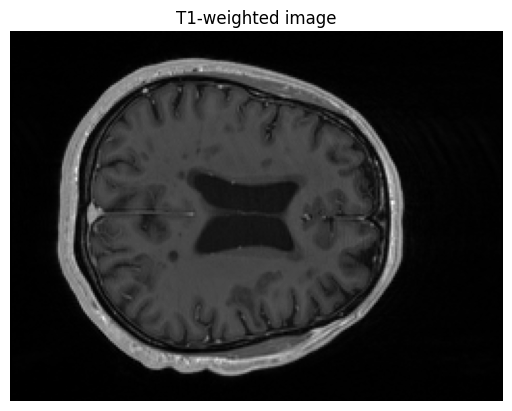

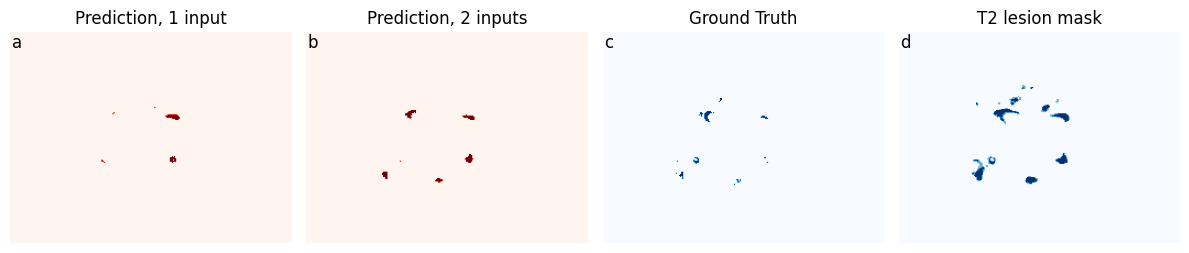

In [27]:
# Plotting a T1-weighted image in addition to the corresponding predicted and true lesion masks
num = ... # Number of the slice to display

comparison(
    image=valid_ds[num]["image"],
    prediction1=preds1_val[num],
    prediction2=preds2_val[num],
    label=labels2_val[num],
    slice_idx=99,
    les_mask=valid_ds[num]["lesion_mask"],
    show_image=True
)

### Test data

To assess generalization performance, the selected models were evaluated on an unseen test set. Both quantitative (DSC) and qualitative (segmentation visualizations) results are reported.

In [28]:
# Computing DSC of model with one input on test dataset
dice1_test, preds1_test, labels1_test = evaluate_performance(model_1_channel, test_loader)
dice1_test

0.23603998124599457

In [29]:
# Computing DSC of model with two inputs on validation dataset
dice2_test, preds2_test, labels2_test = evaluate_performance(model_2_channel, test_dl, les_mask=True)
dice2_test

0.452700674533844

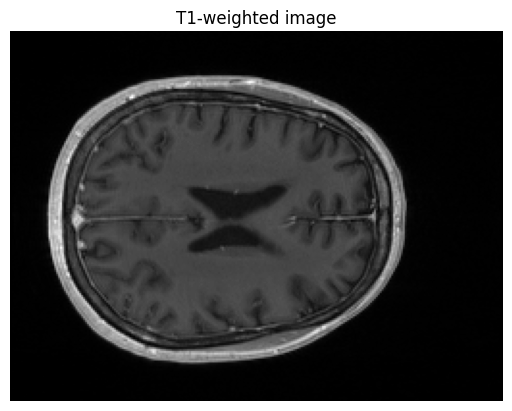

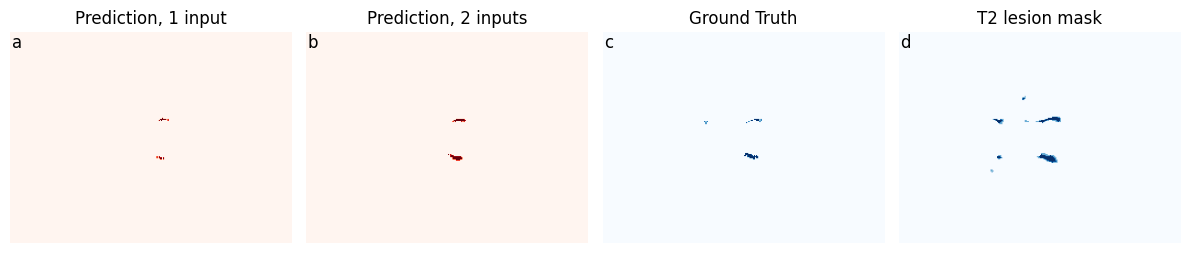

In [32]:
# Plotting a T1-weighted image in addition to the corresponding predicted and true lesion masks
num = ... # Number of the slice to display

comparison(
    image=test_ds[num]["image"],
    prediction1=preds1_test[num],
    prediction2=preds2_test[num],
    label=labels2_test[num],
    slice_idx=99,
    les_mask=test_ds[num]["lesion_mask"],
    show_image=True
)